# Необходимые подключения

In [6]:
from google.colab import drive

from heapq import nlargest

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")

import re
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

drive.mount("/content/drive")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c2cfa961836f6a070f3111bc6c4f3402e77f8bb811ec96dba03a444e8882b1ad
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Mounted at /content/drive


# 1.1 Загрузка данных

In [7]:
tatarDf = pd.read_excel("drive/MyDrive/ВПК_2-2/Модели_и_методы_инженерии_знаний/Лабораторная_работа_11/Датасет_Заявки_2019-2020_Республика_Татарстан.xlsx")
print(tatarDf.head(3))

  Дата подачи заявки    Долгота     Широта  \
0         2019-01-01  51.339734  55.417592   
1         2019-01-01  52.456953  54.603573   
2         2019-01-01  49.126253  55.792942   

                                               Адрес  \
0  Чистополь — Нижнекамск, Ачи, Нижнекамский райо...   
1  29, Ленинградская улица, городское поселение Л...   
2  Россия, Республика Татарстан, Казань, улица Га...   

        Категория, присвоенная модератором  \
0               Благоустройство территории   
1               Благоустройство территории   
2  Содержание и ремонт муниципальных дорог   

                                     Описание заявки  \
0  На трассе Нижнекамск-Чистополь в лесополосе у ...   
1  Во дворе дома Ленинградская 29 отсутствуют пар...   
2  Добрый день! Не осуществляется уборка снега в ...   

                               Последний исполнитель  id исполнителя  \
0  Исполнительный комитет Нижнекамского муниципал...         22291.0   
1  Исполнительный комитет Лениногорс

# 1.2 Чистка и обработка данных

Для начала, оценим количество заявок с пропущенными значениями.

In [ ]:
print(f"Количество всех заявок = {len(tatarDf.index)}")
print(f"Количество полных заявок = {len(tatarDf.dropna().index)}")

difference = len(tatarDf.index) - len(tatarDf.dropna().index)
print(f"Количество неполных заявок = {difference}")
percent = difference / (len(tatarDf.index) / 100)
print(f"Количество неполных заявок составляет {round(percent, 1)} % от исходного количества всех заявок")

Количество всех заявок = 29018
Количество полных заявок = 27983
Количество неполных заявок = 1035
Количество неполных заявок составляет 3.6 % от исходного количества всех заявок


Как видно из вывода выше, кол-во неполных заявок составляет примерно 3,6 %

В последнем элементе dataframe лежит сразу сразу несколько заявок.

Не знаю с чем это связано, но их определенно нужно распарсить. Код с парсингом ниже

Как оказалось позднее, таких "многослойных" заявок намного больше. К счастью, код ниже справился со всеми из них и наши данные практически не пострадали :)

In [ ]:
newBids = []
mayBeEmptyCols = ["Описание заявки", "Последний исполнитель", "id исполнителя", "Статус заявки"]
oldLen = len(tatarDf.index)
a = "\\"
for i in range(len(tatarDf.index)):
  if "_x000D_" in str(tatarDf.iloc[i]["Описание заявки"]):
    newBids = tatarDf.iloc[i]["Описание заявки"].split('_x000D_') #Разделяем заявки построчно
    newBids = [nBid.split("$$") for nBid in newBids] #Раскидываем строки по своим столбцам
    for j, bid in enumerate(newBids):
      if j != 0:
        ser = {c: b.replace("\n", "").replace("\\", "").replace("•", "").replace("\t", "").replace("\\", "").replace(f"{a}", "") for c, b in zip(tatarDf.columns, bid)}
        print(ser)
        tatarDf = tatarDf.append(ser, ignore_index = True)
      else:
        for k, column in enumerate(mayBeEmptyCols):
          try:
            tatarDf.at[i, "Описание заявки"] = bid[k].replace("\n", "").replace("\\", "").replace("•", "").replace("\t", "")
          except:
            pass
newLen = len(tatarDf.index)

{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного или информационного сообщения'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': ''}
{'Дата подачи заявки': 'Превышен допустимый размер высоты опоры от уровня земли до нижнего края рамки – 4,3 м, - особенностей рельефа местности и объектов - нет'}
{'Дата подачи заявки': '2019-01-04', 'Долгота': '49.109858851880', 'Широта': '55.841157713254', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Гагарина', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Большая просьба убрать снег с проезжей части по ул.Гагарина. Сейчас самое благоприятное время, заводчане отдыхают, машин вдоль дорог практически нет. При следующем снегопаде, проезд и уборка снега, будет сильно затруднена.', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-01-04', 'Долгота': '48.267011046410', 'Широта': '54.966813572465', 'Адрес': 'улица Комарова, городское поселение Буинск, Буинский район,

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-01-05', 'Долгота': '49.159067664295', 'Широта': '55.839231980792', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Гаврилова, 44', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'На столбе отсутствует табличка с номерами автобусных маршрутов. Сама рамка для таблички есть. Просьба установить табличку.', 'Последний исполнитель': 'Комитет по транспорту', 'id исполнителя': '27827', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-01-05', 'Долгота': '49.159748812617', 'Широта': '55.839706594041', 'Адрес': 'Казань, улица Гаврилова, 44А', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-01-05', 'Долгота': '51.793579459190', 'Широта': '55.619370813374', 'Адрес': 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '21.12.2018 в 13:45'}
{'Дата подачи заявки': '2557527: Тротуар не расчищается от снега'}
{'Дата подачи заявки': '03.12.2018 в 16:55'}
{'Дата подачи заявки': 'Тротуар по ул. Шевченко от выезда АЭС и до ул. Радищева зимой не чистят от снега. Заявка подается после каждого выпадения снега.'}
{'Дата подачи заявки': '2019-01-17', 'Долгота': '49.123050013676', 'Широта': '55.763022130042', 'Адрес': 'улица Тимер Юл, Юл Урам, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420106, РФ', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Просьба установить', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-01-17', 'Долгота': '49.222677790440', 'Широта': '55.794160859720', 'Адрес': 'Казань, улица Джаудата Файзи, 14А', 'Категория, присвоенная модератором

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-01-17', 'Долгота': '49.107975234747', 'Широта': '55.819761118631', 'Адрес': 'Казань, Чистопольская улица, 11', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Восстановить знак P (парковка).', 'Последний исполнитель': 'Комитет по транспорту', 'id исполнителя': '27827', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-01-17', 'Долгота': '49.113176302417', 'Широта': '55.819139389011', 'Адрес': 'Казань, Чистопольская улица, 22', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Надо почистить проезд с удалением отвалов снега от прежних чисток из парковочных карманов вдоль домов 20, 22 и 26 по Чистопольский.'}
{'Дата подачи заявки': 'Нарушение пунктов 25.1, 29.9(1) Правил благоустройства г.Казани, утверждённых решением Казанской городской Думы от 16.04.2014г N 4-12, средства размещения наружной информации должны размещаться и эксплуатироваться в соответс

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-06', 'Долгота': '49.128814458782', 'Широта': '55.799502293084', 'Адрес': '4, улица Адамюка, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420015, РФ', 'Категория, присвоенная модератором': 'Парки и скверы', 'Описание заявки': 'После первой заявки повесили цепь   ее сорвали  надо повесить замок', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-06', 'Долгота': '52.383863925934', 'Широта': '54.939134356689', 'Адрес': 'Россия, Республика Татарстан, Альметьевск, микрорайон Урсала, Советская улица, 219', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Уже почти неделю на заборе у соседей весит собака, на обращения к ним убрать и захоронить, нет никакого реагирования, прошу принять меры.', 'Последний исполнитель': 'Исполнительный комитет Альметьев

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-08', 'Долгота': '53.233708495281', 'Широта': '54.401396452260', 'Адрес': 'городское поселение Бавлы, Бавлинский район, улица Салиха Сайдашева, 1Б', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Добрый вечер. Висят электрические провода, которые идут к вагончикам   на вокзале. Соединения еле держаться. Создается опасность для людей. Прошу устранить.', 'Последний исполнитель': 'Исполнительный комитет Бавлинского муниципального района РТ', 'id исполнителя': '12030', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-08', 'Долгота': '53.245646056785', 'Широта': '54.415009133095', 'Адрес': 'городское поселение Бавлы, Бавлинский район, Степной переулок', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Не чистят от снега верхнюю сторону переулока Степной. За всю зиму раз 2-3 только заезжал трактор, все остальное время приходится самим все чистить. Машин

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-09', 'Долгота': '52.433061171323', 'Широта': '55.740294535276', 'Адрес': 'Россия, Республика Татарстан, Набережные Челны, проспект Вахитова', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'Добрый вечер. В пятницу 8 февраля с 17. 00 после работы на остановке 40 лет Победы ждала № 26 автобус. В итоге прождала 40 минут, вся замерзла. Все 26 проезжали мимо не останавливались.  Проехало 4 оранжевых автобуса. У них же маршрут, что за безобразие. Что хотят то и творят.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-09', 'Долгота': '52.357277870178', 'Широта': '55.728989034740', 'Адрес': 'Набережные Челны, Портовая улица, 47', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'После каждого выпадения осадков, складируют снег возле детской площадки', 'Последний исполн

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-09', 'Долгота': '51.769477128983', 'Широта': '55.609184107967', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Афанасовская улица, 44', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Снова не чистят дорогу, только после обращения в народный контроль начинается очистка', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-09', 'Долгота': '51.789411306381', 'Широта': '55.620920608731', 'Адрес': 'проспект Химиков, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': '9 февраля дорога пр. Химиков  не чищена, тротуары песком не посыпаны, машины выбрасывает из колеи.Из автобуса тоже выходить сложно , с к о л ь з к о

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '1994882 заявка была выполнена, но снова не горит! Днем доступ спецтехники имеется!'}
{'Дата подачи заявки': 'на детплощадке,въезде в ЖК,мусорке,входе в дом. Прошу снова выехать и при выезде связаться со мной.'}
{'Дата подачи заявки': 'Фотографии сделаны 20.02.2019 в 6:20'}
{'Дата подачи заявки': 'При выезде постоянно создаются аварийные ситуации, так как с левой стороны большой сугроб, ограничивающий обзор. Данная проблема возникла снова. Необходимо устранить.'}
{'Дата подачи заявки': '2019-02-21', 'Долгота': '52.410540582205', 'Широта': '55.755139268049', 'Адрес': '47/36-1, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423819, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Пожалуйста уберите снег за домом 47/36/1 г. Набережные Челны, дорога принадлежит Исполкому г. Набережные Челны, штрафуют УК, а ИК сам не убирает снег!!!!'

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-21', 'Долгота': '49.183822944760', 'Широта': '55.744904673899', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Академика Парина, 16', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Вдоль дома тротуары не чистят вообще!!!', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-21', 'Долгота': '49.241393208504', 'Широта': '55.780544404014', 'Адрес': '3, улица Тыныч, Азино-1, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420100, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'На 17-18 этажный, пяти подъездный дом два кармашка для парковки машин. На данный момент кармашки завалены снегом! За место того что бы вывезти снег, с начала зимы, начали складывать перед подъездом. Прошу оказать 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-21', 'Долгота': '52.373632546824', 'Широта': '55.742859454175', 'Адрес': 'Набережные Челны, 12/10', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В то время, когда В. В. Путин борется как раб на галерах с полной отдачей сил за сохранение здоровья будущего нашего поколения, коммунальщики вытворяет обратное, - создают вред нашим детям, в частности складируют грязный снег с дороги( пропитанный вредными молекулами) на песочниц', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-21', 'Долгота': '49.057756705206', 'Широта': '55.831164720679', 'Адрес': 'Казань, Окольная улица, 17В', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Здравствуйте,много снега вдоль домом по проезжей части дороги,на парковке,не возможно выехать на машине и пройти пешком.Тр

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-21', 'Долгота': '49.228647896651', 'Широта': '55.756772800000', 'Адрес': '12, улица Академика Завойского, Азино-2, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420141, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Не производится уборка снега', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-21', 'Долгота': '49.133583523653', 'Широта': '55.787130215613', 'Адрес': '11, Катановский переулок, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420012, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Не производится очистка дороги от снега, невозможно разъехаться двум машинам.', 'Последний исполнитель': 'Администраци

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Бред, сегодня 22.02.19г, туалет не работает, никаких объявлений, просьба принять меры.'}
{'Дата подачи заявки': '2019-02-22', 'Долгота': '49.022030328269', 'Широта': '55.866500236683', 'Адрес': '69Г, Беломорская улица, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420085, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Возле дома 69Г по улице Беломорская Авиастроительного района г Казани коммунальные и / или дорожные службы устроили свалку снега. С ближайшего рынка и дворов свозят снег и свалтвают около жилого дома.', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-22', 'Долгота': '52.349132209965', 'Широта': '55.675617962494', 'Адрес': 'микрорайон Замелекесье 26, ЗЯБ, Комсомольский район, Набережные Челны, городской округ Набе

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-02-22', 'Долгота': '52.440295507149', 'Широта': '54.587641991393', 'Адрес': 'городское поселение Лениногорск, Лениногорский район, улица Садриева, 65', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Весной будет тяжело выезжать и заезжать.', 'Последний исполнитель': 'Исполнительный комитет Лениногорского муниципального района', 'id исполнителя': '22281', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-22', 'Долгота': '52.402167320251', 'Широта': '55.750605553062', 'Адрес': '45 комплекс, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423823, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'За зиму ни разу не производилась уборка тротуара от снега вдоль дома 45/01! Необходимо произвести очистку до асфальтового покрытия!', 'Последний исполнитель': 'Муниципальное образ

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-02-22', 'Долгота': '49.145975299180', 'Широта': '55.777361428291', 'Адрес': 'Россия, Республика Татарстан, Казань, жилой массив Калуга', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Каждый день вожу ребенка в садик по этой дороге, младший в санках,еле пробираемся через снежные завалы, есть только одна тропинка по которой очень сложно проехать даже на санках, другая часть вообще не понятно, края почистили середину оставили', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-02-22', 'Долгота': '52.285673601594', 'Широта': '54.898637700000', 'Адрес': 'Россия, Республика Татарстан, Альметьевск, Альметьевский район, улица Ленина, 90', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Ни разу за зиму не убирался снег во дворе. Пройти пешком невоз

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-03-06', 'Долгота': '49.193676710129', 'Широта': '55.799495960867', 'Адрес': '49А, улица Космонавтов,  Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420061, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'не убранный снег тает,глубокая ледяная колея,огромные лужи,не проехать,не пройти', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-03-06', 'Долгота': '49.218922499567', 'Широта': '55.805034594108', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Зирекле', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Проезд к СНТ Беркут (и еще два СНТ), а также жилым домам на легковом автомобиле невозможен. Проезд не очищается от снега.Скорая помощь также не сможет заехать.Просим, хотя бы , один раз в неделю очищать

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-03-21', 'Долгота': '51.789679527283', 'Широта': '55.639264821169', 'Адрес': '17, улица Фикрята Табеева, 47-й микрорайон, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423585, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Невозможно ходить по дороге между д/с 95 и школой 36,каша снежная, лужи поколено, почему нельзя это вовремя убрать не дожидаясь жалоб!!!!!!!', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-03-22', 'Долгота': '52.289600372314', 'Широта': '55.676971234382', 'Адрес': '7/3, ГЭС, Комсомольский район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423850, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Грузовые автомобили

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-03-22', 'Долгота': '49.170399036739', 'Широта': '55.720687689328', 'Адрес': 'улица Рауиса Гареева, 33-й Военный городок, Ферма-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420011, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Прошу расширить дорожное полотно на перекрестке ул. Гариева и выезд из СК Тулпар. Сейчас машины стоящие возле сфетофора перекрывают вьезд в спорткомплекс. Со строны Фермы с ул. Гариева сложно и опасно заезжать в Тулпар.', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-03-22', 'Долгота': '52.430405616760', 'Широта': '55.753552058039', 'Адрес': 'Набережные Челны, 28/08', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'У арки 28/07 Собирается вода весной

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-04-01', 'Долгота': '49.034488743855', 'Широта': '55.882240388385', 'Адрес': '11, улица Ак Каен, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420091, РФ', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'Стая собак живет рядом с  снт сирень, место , где они живут указано на карте. Боимся пройти мимо, бросаются лаем. От них вокруг кости и ...', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-04-01', 'Долгота': '51.795392632484', 'Широта': '55.619455631514', 'Адрес': '36, улица Юности, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В связи с установкой знаков стоянка запрещена за домом Юности,36, возник дефицит парковочных 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-04-01', 'Долгота': '49.882528502494', 'Широта': '55.428536211704', 'Адрес': 'Россия, Республика Татарстан, Рыбно-Слободский район, село Большая Елга, Ключевая улица', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Столб наклонился, и держится только на вводном кабеле в дом, он уже очень сильно натянут.', 'Последний исполнитель': 'Исполнительный комитет Рыбно-Слободского муниципального района', 'id исполнителя': '22230', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-04-01', 'Долгота': '48.560616374016', 'Широта': '55.856348016234', 'Адрес': '21А, улица Комарова, Мирный, городское поселение Зеленодольск, Зеленодольский район, Татарстан, Приволжский федеральный округ, 422545, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Предприниматели с площади перед магазином ПОЗИС снег со своей территории не вывозят на полигон, а бульдозером сваливают на за

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-04-01', 'Долгота': '49.148358106613', 'Широта': '55.764836003914', 'Адрес': '118, улица Павлюхина, Воскресенский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420087, РФ', 'Категория, присвоенная модератором': 'Поликлиники и больницы', 'Описание заявки': 'Уже две недели не могу записаться к врачу офтальмологу.1.04.19 с утра пошла в поликлинику хотела попасть по живой очереди на приём.пришла к пол 9.по записи был один человек после него хотела зайди я,ну на что мне врач ответила что без записи не принимаем.как попасть к врачу?', 'Последний исполнитель': 'Министерство здравоохранения Республики Татарстан', 'id исполнителя': '81', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-04-01', 'Долгота': '48.895265600000', 'Широта': '55.874030500000', 'Адрес': 'Осиново, Зеленодольский район, улица Гагарина, 6', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявк

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-04-01', 'Долгота': '49.073540568352', 'Широта': '55.827428634001', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Шамиля Усманова, 11Б', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Обращаюсь к Вам с жалобой на неправомерные действия нескольких жителей дома, расположенного по адресу Шамиль Усманова 11Б, выразившиеся в следующем:'}
{'Дата подачи заявки': 'не соответствует не каким санитарным нормам.'}
{'Дата подачи заявки': 'Просьба произвести отлов.'}
{'Дата подачи заявки': '       Бойлер горячего водоснабжения установлен, но до конца не укомплектован, горячей воды нет.'}
{'Дата подачи заявки': 'Просим помочь в решении данного вопроса.'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2.Сиденье сделано из элементов металлических труб:во время раскачивания ребёнок может упасть и получить сильный удар сиденьем по голове'}
{'Дата подачи заявки': '3.Качель является препятствием, которого ребёнок не ожидает и которое может стать причиной травм'}
{'Дата подачи заявки': 'В процессе эксплуатации указанной дороги под воздействием колес тяжелой техники, каждодневно проходящей к вновь строящимся домам в поле, а также других транспортных средств автомобильная дорога износилась'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': ' - ямы практически все глубиной более 5см. Найдите ответственных и приведите дорожное покрытие в соответствующее состояние!'}
{'Дата подачи заявки': 'Просьба проверить законность  размещения самого павильона  и законность захвата существующего тротуара с высокой интенсивностью движения пешеходов. Кто согласовал металлический лестничный пролет, перекрыва'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': 'Пт-Прививки. Только в эти дни.'}
{'Дата подачи заявки': 'Перед прививкой необх сдавать анализы. На сегодня нужен талон на кровь. Прием с 9, чтобы успеть взять талон необх придти к 8 (кто успел тот и взял-всего их 40шт).ЦРБ Пестр р.больше не выдает для ФАП. Примите меры'}
{'Дата подачи заявки': ' Заявка №2523126 не выполнена, отписана формально.'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': ' участвовавших в ВОВ.'}
{'Дата подачи заявки': 'Участок 9, каб.32'}
{'Дата подачи заявки': 'Если делать ничего так и не собираются, отдайте площадку под парковку сос.домам'}
{'Дата подачи заявки': '2682809).'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': 'Так как мусорка находится не далеко от проезжей части, все проезжающие на машинах выбрасывают свой мусор в эту емкость, а чаще оставляют рядом . Ветром мусор разносит по дороге'}
{'Дата подачи заявки': 'на стороне Б – отсутствует обязательная рамка'}
{'Дата подачи заявки': '2019-04-30', 'Долгота': '49.077952303523', 'Широта': '55.798061335129', 'Адрес': 'Казань, улица Кировская Дамба', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Металлоконструкции жд моста в неприглядном состоянии. Необхадимо покрасить.', 'Последний исполнитель': 'Министерство транспорта и дорожного хозяйства Республики Татарстан', 'id исполнителя': '9933', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-04-30', 'Долгота': '49.180458784103', 'Широта': '55.745865318855', 'Адрес': 'Казань, улица Карбышева, 61', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Необходимо починить забортная дет

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-04-30', 'Долгота': '51.785557626495', 'Широта': '55.618755200777', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, проспект Химиков, 7А', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Участок тротуара, пересекающий дорогу, оставляет желать лучшего. Бетон весь выкрашивается, из-за чего очень неудобно ходить, обувь портится от чрезмерной неровности поверхности. Заасфальтируйте указанный участок тротуара. И не откладывайте заявку на неопределенный срок.', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-04-30', 'Долгота': '49.015289526433', 'Широта': '55.866776655396', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Химиков', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'На пересечении улиц Беломорская и Химиков мусорка

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Однако, если вблизи школ №2,3,4,5 работы по о'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.193494319916', 'Широта': '55.757126207938', 'Адрес': 'Казань, улица Рихарда Зорге, 24', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'С проводов свисает железный прут', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.058630140280', 'Широта': '55.838293818348', 'Адрес': 'Казань, улица Академика Королёва, 69', 'Категория, присвоенная модератором': 'Санитарное состояние', 'Описание заявки': 'В парке им,Урицкого завелись Клещи,наподают на Животных кусают их.Страшно и опасно гулять по парку с детьми,срочно нужна обработка.', 'Последний исполнитель': 'Управление Роспотребнадзор по РТ', 'id исполнителя': '24397', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.069050550461', 'Широта': '55.811719155202', 'Адрес': '8, улица Алафузова, Ягодная слобода, Кировский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420032, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Никто не проводит уборку на против «Доброй столовой» и офисов. Люди приезжают в столовую и к водонапорной колонке, мусорят, ходят в туалет, заставляют проезд автомобилями. Кто несёт ответственность за порядок? Примите меры!', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.224552288651', 'Широта': '55.769608776942', 'Адрес': '10, Минская улица, Азино-2, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420140, РФ', 'Категория, присвоенная модератором': 'Парки и скверы', '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-09', 'Долгота': '50.810007378459', 'Широта': '54.432778256061', 'Адрес': 'Россия, Республика Татарстан, Нурлат, Центральный парк', 'Категория, присвоенная модератором': 'Парки и скверы', 'Описание заявки': 'В центральном парке города, у памятника Участникам всех боевых действий, не убрали старую гирлянду, которую возложили ещё в феврале. И это все в День Победы 9 мая 2019 года.', 'Последний исполнитель': 'Исполнительный комитет Нурлатского муниципального района', 'id исполнителя': '22218', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '50.809760615230', 'Широта': '54.432873445266', 'Адрес': 'Россия, Республика Татарстан, Нурлат, Центральный парк', 'Категория, присвоенная модератором': 'Парки и скверы', 'Описание заявки': 'Мемориальная техника в парке не подготовлена обшивка на башне танка развевается на ветру как флаг позора. Таблички с описанием техники пустые.', 'Последний исполнитель': 'Исполнительный комитет Нурлат

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.226173500000', 'Широта': '55.750152500000', 'Адрес': 'Казань, улица Юлиуса Фучика, 5', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Огромная просьба очистить тротуар от грязи и мусора по всей его ширине-от поребрика до поребрика', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.186968479189', 'Широта': '55.794303005356', 'Адрес': 'Казань, улица Патриса Лумумбы, 58', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Не вывозят мусор.', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.091978073120', 'Широта': '55.794785725217', 'Адрес': 'Россия, Республика Татарст

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.104845681186', 'Широта': '55.742346466813', 'Адрес': 'Казань, Магистральная улица', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Не работает целый день светофор', 'Последний исполнитель': 'Государственное казенное учреждение «Главное управление содержания и развития дорожно-транспортного комплекса Татарстана при Министерстве транспорта и дорожного хозяйства Республики Татарстан» ГКУ «Главтатдортранс»', 'id исполнителя': '9934', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.132078580930', 'Широта': '55.775762484592', 'Адрес': 'Казань, улица Марселя Салимжанова, 12', 'Категория, присвоенная модератором': 'Санитарное состояние', 'Описание заявки': 'Подойти к подъезду страшно. Ползают эти твари. А с наступлением лета и открытыми окнами они теперь и в квартиры заползают. Они огромные и страшные. Уже не первый год не могу вывести. Сколько уже можно это те

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.198440313339', 'Широта': '55.840175068224', 'Адрес': 'Казань, Сибирский тракт, 59', 'Категория, присвоенная модератором': 'Мобильная связь', 'Описание заявки': 'Мегафон 4G скорость интернета пролохое. Пропадает 4G.', 'Последний исполнитель': 'Министерство цифрового развития государственного управления, информационных технологий и связи Республики Татарстан', 'id исполнителя': '947', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-09', 'Долгота': '49.303990602493', 'Широта': '55.918658317178', 'Адрес': 'Высокая Гора, Высокогорский район, Полковая улица, 4', 'Категория, присвоенная модератором': 'Воздух', 'Описание заявки': 'Все время с улицы попадает это зловонный запах едкого дымка.Самочувствие сразу меняется,головокружение сопровождает с момента появления запаха. При обращении взора на сторону предполагаемого прихода запаха нередко можно увидеть рыжим дым.Примите меры,нас травят.', 'Последний исполнитель': 'Управлен

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.083543011493', 'Широта': '55.814853118931', 'Адрес': 'Казань, улица Баженова, 28', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Нужно закрасить рекламу наркотиков.', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '51.813014249346', 'Широта': '55.618814386502', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Вокзальная улица', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Лежат груды мусора после строительства данного торгового центра. Территория изгажена строительным мусором. Хотя в самой стройландии чисто.', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-10', 'Дол

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.149861800000', 'Широта': '55.771657600000', 'Адрес': '7, Газовая улица, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420049, РФ', 'Категория, присвоенная модератором': 'Санитарное состояние', 'Описание заявки': 'Очень много комаров 2-ой год подряд. Необходимо обработать зеленые зоны в этом районе.', 'Последний исполнитель': 'Управление Роспотребнадзор по РТ', 'id исполнителя': '24397', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '53.389847980070', 'Широта': '55.511406646107', 'Адрес': 'Мензелинский район', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'На въезде в деревню Новое Айманово отсутствуют знаки с началом и окончанием населённого пункта.', 'Последний исполнитель': 'Исполнительный комитет Мензелинского муниципального района', 'id исполнителя': '22292', 'Статус заявки': 'Заявка решена'}
{'Дата подач

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.197946786880', 'Широта': '55.839042487677', 'Адрес': 'Казань, Сибирский тракт, 55/1', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Возле остановки общественного транспорта поврежден электрощит. Необходимо провести ремонтные процедуры для обеспечения безопасности пешеходов.', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '52.808328866959', 'Широта': '54.544735498258', 'Адрес': 'Россия, Республика Татарстан, Бугульминский район, Мусульманское кладбище', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'На новом мусульманском кладбище, как и на всех в нашем городе, горы мусора, которые не вывозят!', 'Последний исполнитель': 'Исполнительный комитет Бугульминского муниципального района', 'id исполнителя': '22255', 'Статус заявки'

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.120817184448', 'Широта': '55.784295937352', 'Адрес': 'Казань, улица Марселя Салимжанова, 1', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Закрыть отверстие', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '50.564464109884', 'Широта': '55.376120931562', 'Адрес': 'городское поселение Чистополь, Чистопольский район', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Отсутствует асфальтовое покрытие улицы Хлебная поселка Крутая Гора  города Чистополь.  Необхадимо привести в нормативное состояние.', 'Последний исполнитель': 'Исполнительный комитет Чистопольского муниципального района', 'id исполнителя': '22278', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.117738008499', 'Широта': '55.7

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-10', 'Долгота': '50.564145982280', 'Широта': '55.379773351850', 'Адрес': 'городское поселение Чистополь, Чистопольский район', 'Категория, присвоенная модератором': 'Работа учреждений культуры', 'Описание заявки': 'Здания клуба в посёлке Крутая Гора  города Чистополь в плачевном состоянии. Окна выбиты.  Двери открыты и сломаны.  Внутри валяется мусор.  Нужен срочный ремонт!', 'Последний исполнитель': 'Исполнительный комитет Чистопольского муниципального района', 'id исполнителя': '22278', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-05-10', 'Долгота': '49.107320308685', 'Широта': '55.788766083749', 'Адрес': 'Казань, улица Гаяза Исхаки, 10', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Повесить паспорт обьекта', 'Последний исполнитель': 'Комитет Республики Татарстан по охране объектов культурного нaследия', 'id исполнителя': '75681', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-05-10',

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-22', 'Долгота': '49.195050001144', 'Широта': '55.757150365697', 'Адрес': 'Россия, Республика Татарстан, Казань, Приволжский район, улица Рихарда Зорге, 24', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'в связи с проводимым ремонтом тротуаров и дорог утрачен съезд на старый пеш. асфальтированный проход, старый тротуар не облагорожен, съезд на него для колясок не предусмотрен - положили бордюр, тоже самое на стихийно вытоптанной тропе от парковки ст.метро горки до пеш.перех. Бр.К', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-05-22', 'Долгота': '49.063694697663', 'Широта': '55.822491980631', 'Адрес': 'Казань, улица Батыршина, 39', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Закрасить граффити', 'Последний исполнитель': 'Админист

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-22', 'Долгота': '52.443515523300', 'Широта': '55.753784508488', 'Адрес': 'Набережные Челны, 27/16', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Детям домов 27/17 и конец 27/16 негде гулять. Нет ни песочницы, ни качелек, ни горки.  Стоит 80-х годов слоник и лабиринт. Песок высыпали под слоником.Вынуждены гулять на площадках других домов. Прошу помочь решить эту проблему.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-22', 'Долгота': '52.438838481903', 'Широта': '54.599349645791', 'Адрес': 'Торговая галерея, 6, улица Кутузова, городское поселение Лениногорск, Лениногорский район, Татарстан, Приволжский федеральный округ, 423250, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Такое состояние не первый год. Никто не восстанавливает. :

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.134987965226', 'Широта': '55.838241768943', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Фатыха Амирхана, 24А', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': '4 либо 5 гаражей незаконно построенный на площади', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.156243801117', 'Широта': '55.842813611955', 'Адрес': 'Казань, улица Гаврилова, 56 к7', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Не работают фонари ночного освещения по улице Гаврилова на против дома 56 корпус 7 и корпус 6.в этом месте делают дороги, а света нет в ночное время.', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.098921614859', 'Широта': '55.845089501027', 'Адрес': 'Казань, улица Михаила Миля', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'На подходе в платформе 795 км и на стоянке разгуливают бродячих сабаки', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.208686351776', 'Широта': '55.769319321712', 'Адрес': 'Автодорстрой, улица Рылеева, Дальний, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420089, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Демонтируйте', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.185742735863', 'Широта': '55.776966366410', 'Ад

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-23', 'Долгота': '52.429080496313', 'Широта': '54.594851263516', 'Адрес': '12, Степная улица, городское поселение Лениногорск, Лениногорский район, Татарстан, Приволжский федеральный округ, 423259, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Разбит въезд дороги на 17 дом относящийся к ул.Степная,2 год не могут сделать нормальный вьезд', 'Последний исполнитель': 'Исполнительный комитет Лениногорского муниципального района', 'id исполнителя': '22281', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.149312973022', 'Широта': '55.784009296751', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Вишневского, 14', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'На пешеходном переходе возле здания Вишневского,16 стоит лужа, затрудняющая движение пешеходов. Необходимо поднять уровень асфальта, либо установить л

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-23', 'Долгота': '52.421366800000', 'Широта': '55.757562800000', 'Адрес': 'Набережные Челны, Автозаводский проспект', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Перед  24 школой нет тротуара, грязь, земля, там где тротуар есть, он разбит, лужи, постоянно ставят машины перед окнами 20/02', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.122699089348', 'Широта': '55.834578656050', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Маршала Чуйкова, 22', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'На детской площадке песочница вкруговую в торчащих гвоздях и щепках от сломанных деревянных листков, а также давно не завозили песок', 'Последний исполнитель': 'ООО Управляющая компания Уютный дом', 'id исполнителя': '73197', 'Статус за

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-05-23', 'Долгота': '49.121911525726', 'Широта': '55.832265434431', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Мусина, 53', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В прошлом году по моему обращению наконец-то отремонтировали муниципальную дорогу между детскими садам. однако на одном участке пешеходная дорога уходит в сторону, а прямо отсутствует, приходится людям идти по проезжей части. Прошу продолжить пешеходную дорогу прямо', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-23', 'Долгота': '53.126272924565', 'Широта': '54.510432263830', 'Адрес': 'Крым-Сарайское сельское поселение, Бавлинский район, 16К-0509', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Требуется капитальный ремонт автодороги Ак баш- пе

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.230642914772', 'Широта': '55.767096039852', 'Адрес': 'Россия, Республика Татарстан, Казань, Ломжинская улица, 17/1', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'Отсутствуют знаки о запрете курения на остановке', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.131739139557', 'Широта': '55.824677540438', 'Адрес': 'улица Амирхана д. 21, подъезд 2, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420126, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Трещины,выбоины,ямы на лестнице у входа в подъезд 2, пол бугристый с ямами, по нему сложно ходить. После дождя в ямах на верхней площадке лестницы скапливаются лужи, в месте выхода из подъезда, обойти невозможно.', 'Последний и

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.121412183831', 'Широта': '55.827331822094', 'Адрес': 'Казань, проспект Ямашева', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'После дождя и мойки керхером стен перехода падает плитка. А также образуется большая лужа в конце лестницы, которую люди перепрыгивают. Почините.', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.073363542557', 'Широта': '55.809197952715', 'Адрес': 'Казань, улица Энгельса, 19', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Добрый день, вдавленный люк в асфальт, напротив д.19 ул. Энгельса. Прошу устранить', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.236128568518', 'Широ

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '52.298774400000', 'Широта': '55.680682800000', 'Адрес': 'Набережные Челны', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу произвести уборку на территории детской площадки.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '52.444235086441', 'Широта': '55.749518671268', 'Адрес': '52/20А, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423827, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Мусорные баки находятся очень близко к зданию постоянная грязь,мухи и запах. Просим убрать на расстояние согласно норм минимум 20 метров', 'Последний исполнитель': 'Управление Роспотребнадзор по РТ', 'id исполнителя': '24397', 'Статус заявки': 'Мот.о

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.085918300000', 'Широта': '55.817317100000', 'Адрес': 'Казань, Горсоветская улица, 25', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Около дома по адресу горсоветская 25, ямы на муниципальной дороге растут чуть ли не каждый день. Прошу принять во внимание обращение и решить проблему. В настоящее время на части улицы проводится ремонт дороги, ямы это не затрагивает', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '51.815847158432', 'Широта': '55.643081316226', 'Адрес': 'проспект Шинников, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'С недавнего времени в нашем городе изменили время движения город

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.173409938812', 'Широта': '55.786938272108', 'Адрес': '35, улица Аделя Кутуя, Октябрьский городок, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420073, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Ужасно выполнили ремонт  асфальта! Переделайте, заплатки волнами и проваливаются! Кто вообще принял такую ужасную работы? Ездим как по стиральной досте', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '51.819430589676', 'Широта': '55.663085457298', 'Адрес': '20 мкр., улица Мурадьяна, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Прошлой осенью обустроили ост

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-05-30', 'Долгота': '49.114881584574', 'Широта': '55.791430807030', 'Адрес': 'Казань, улица Баумана, 19', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Помогите собственникам убрать деревянные постройки. Ресторан уже не работает. Не хватает общественных пространств.', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-05-30', 'Долгота': '48.898800015450', 'Широта': '55.849524751053', 'Адрес': '50, Залесная улица, Залесный, Кировский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420076, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Демонтируйте желтый баннер', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата под

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-06-14', 'Долгота': '48.517879077281', 'Широта': '55.852309080019', 'Адрес': 'Солнечная улица, улица Гоголя, Лесничество, городское поселение Зеленодольск, Зеленодольский район, Татарстан, Приволжский федеральный округ, 422540, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Ранее были установлены жёлтые плитки с полосками (видимо для инвалидов), на сегодняшний день бетон вокруг этих плиток разрушился, при переходе по пешеходному переходу с коляской невозможно заехать. Вот тебе и доступная среда.', 'Последний исполнитель': 'Исполнительный комитет Зеленодольского муниципального района', 'id исполнителя': '22242', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-06-14', 'Долгота': '49.058793783188', 'Широта': '55.818270654265', 'Адрес': '158, Краснококшайская улица, Ягодная слобода, Кировский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420102, РФ', 'Кат

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-06-14', 'Долгота': '51.802414600000', 'Широта': '55.620840500000', 'Адрес': '7, Корабельная улица, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'здравствуйте по улице корабельной дом 7,во дворе дома не  вывозят мусор с пластиковой тарой.', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-06-14', 'Долгота': '52.428718228330', 'Широта': '55.784731105274', 'Адрес': 'улица Николая Майкова, 68 комплекс, Автозаводский район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423826, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В 68 А мкр., вниз по улице Майкова заваливают участок земли , где идет дорог

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-06-14', 'Долгота': '49.147295951843', 'Широта': '55.622907649807', 'Адрес': 'Песчано-Ковалинское сельское поселение, Лаишевский район, Насосная улица, 9А', 'Категория, присвоенная модератором': 'Почта', 'Описание заявки': 'Не возможно получить посылку. Отправляют в Столбище. Как пенсионерам или людям без машин добираться туда.', 'Последний исполнитель': 'УФПСТатарстан Почтасы-филиал ФГУП Почта России"', 'id исполнителя': '27602', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-06-14', 'Долгота': '49.140870427318', 'Широта': '55.769938750000', 'Адрес': '41А, улица Шаляпина, Воскресенский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420106, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Вот такая у нас  детская площадка во дворе дома по ул Шаляпина 41А. Так и до беды недалеко.А эта убогая беседка не видела ремонта и покраски много лет. Ул Шаляпина  41

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': ' Проспект Г.Тукая напротив дома №52.'}
{'Дата подачи заявки': 'Общественный транспорт, доступный для маломобильных пассажиров'}
{'Дата подачи заявки': 'В'}
{'Дата подачи заявки': 'Это нарушение правил благоустройств г.казани. А именно пунктов 155.5, 155.7, 155.11'}
{'Дата подачи заявки': 'Прошу обрезать данное дерево около 1 подъезда.'}
{'Дата подачи заявки': 'Некая инициативная группа вышеназванного дома, руководствуясь исключительно незаконными мотивам'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-07-03', 'Долгота': '49.110627173795', 'Широта': '55.819210122544', 'Адрес': 'ул.Абсалямова, Чистопольская улица, Дружба, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420124, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Положение о порядке установки и эксплуатации рекламных конструкций на территории г.Казани п. 5.1.5 «рекламные конструкции, имеющие внутренний подсвет, должны быть подсвечены в темное время суток. Включение подсвета производится в соответствии с графиком работы уличного освещения'}
{'Дата подачи заявки': ' Бугульма по ул.Краснослободской,ямы.выбоины и т.д'}
{'Дата подачи заявки': '2019-07-08', 'Долгота': '49.181853532791', 'Широта': '55.800605571496', 'Адрес': 'Казань, улица Николая Ершова', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'На газоне между проезжей частью и тротуаром больше недели лежит с

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': ' Пешеходы хаотично выбегают на проезжую часть. Необходимо восстановить забор.'}
{'Дата подачи заявки': 'Предыдущее обращение № 2867967. даже и не знаю как назвать, но вот так делается ремонт... сделать один раз нормально похоже не выходит.... А жаль.'}
{'Дата подачи заявки': 'Не доставляются счета, уведомления из суда. Полный бардак! Сотрудников не ищут, это отписка... подмена текущими не работает'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '52.338603258395', 'Широта': '54.911763470342', 'Адрес': '140, Советская улица, городское поселение Альметьевск, Альметьевский район, Татарстан, Приволжский федеральный округ, 423464, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'При строительстве велодорожек по ул. Советская близ ТК Луч сделали высокий бордюр на пешеходном переходе. Невозможно перейти дорогу в инвалидной коляске, препятствия для велосипедистов и мам с детскими колясками. Просьба сделать по нор

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.195404052734', 'Широта': '55.757524657060', 'Адрес': 'Казань, улица Рихарда Зорге', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Месяц назад продлили дорожку от метро Горки до ул. Братьев Касимовых. Просьба убрать кучи камней и земли, указатели, оставшиеся после этого.', 'Последний исполнитель': 'Государственное казенное учреждение «Главное управление содержания и развития дорожно-транспортного комплекса Татарстана при Министерстве транспорта и дорожного хозяйства Республики Татарстан» ГКУ «Главтатдортранс»', 'id исполнителя': '9934', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.166157245636', 'Широта': '55.730523810803', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Мидхата Булатова', 'Категория, присвоенная модератором': 'Cвалки', 'Описание заявки': 'Сливают нечистоты. Прошу принять меры', 'Последний исполнитель': 'Центральное территориальное

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.219571426511', 'Широта': '55.768336789299', 'Адрес': 'ТРЦ  Южный, проспект Победы, Азино-2, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420140, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Торчит арматурный штырь, необходимо срезать', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.099992513657', 'Широта': '55.859762210193', 'Адрес': 'ул.Максимова, улица Максимова, Соцгород, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420127, РФ', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'После реконструкции дорожного полотна и переноса остановочных павелионов ,не поставили информационные табло,на остановке  общественного транспорт

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.166618585587', 'Широта': '55.738267665993', 'Адрес': '101, Оренбургский проезд, 33-й Военный городок, Ферма-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420059, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.177873134613', 'Широта': '55.734510569323', 'Адрес': 'Оренбургский проезд, Ферма-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420059, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.144255165011', 'Широта': '55.611679919661', 'Адрес': 'Россия, Республика Татарстан, Лаишевский район, село Габишево, Молодёжный проспект, 1', 'Категория, присвоенная модератором': 'Почта', 'Описание заявки': 'Добрый день. Не работает почтовое отделение, не возможно ни отправить почту, ни получить. Как забирать посылки? Написано ОПС работает с 10 до 12. Просьба разобраться', 'Последний исполнитель': 'УФПСТатарстан Почтасы-филиал ФГУП Почта России"', 'id исполнителя': '27602', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.225078839809', 'Широта': '55.795119096632', 'Адрес': 'Россия, Республика Татарстан, Казань, Мамадышский тракт, 8А', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Ключ фикальной воды из-под земли', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.216657282050', 'Широта': '55.802780320007', 'Адрес': 'Казань, Дорожный переулок, 11', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Требуется уборка мусора', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.133069515228', 'Широта': '55.769850420198', 'Адрес': 'Казань, улица Нурсултана Назарбаева, 47/113', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Остановка есть, знака нет', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '52.459008693695', 'Широта': '55.765836826241', 'Адрес': '65/17, Янтарная улица, 65 комплекс, Автозаводский район, Набережные Челны, гор

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.149527549744', 'Широта': '55.731293041341', 'Адрес': 'Запорожская улица, Борисково, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420011, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Незаконная реклама на столбе, необходим демонтаж рекламной конструкции', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-01', 'Долгота': '49.211250543594', 'Широта': '55.742212756729', 'Адрес': '16, улица Юлиуса Фучика, Горки-3, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420138, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Лежат алкаши на диване у подъезда! Срочно увезти его на свалку. Пьют и тут же ссут у людях на виду не стесняются.

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-12', 'Долгота': '49.156863278042', 'Широта': '55.789761077815', 'Адрес': 'Казань, улица Лейтенанта Шмидта, 23', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Сломана песочница , торчат гвозди нет песка', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-12', 'Долгота': '51.788375900000', 'Широта': '55.614272300000', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Вокзальная улица, 38', 'Категория, присвоенная модератором': 'Капитальный ремонт', 'Описание заявки': 'Сделайте входню дверь нормально,в тамбуре сделайте ремонт,на пятом этаже уже кирпич отлетает', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-12', 'Долгота': '49.144890094176', 'Ши

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-12', 'Долгота': '51.798314900000', 'Широта': '55.643745400000', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, улица Сююмбике, 9', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Невозможно перейти пешеходный переход в дождливую погоду (огромная лужа при входе на переход). Скоро учебный год. Переход детям, взрослым с колясками очень затруднён!!! Это единственный пешеходный переход в 31 мкр. Прошу поднять уровень асфальта во избежании образования лужи', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-12', 'Долгота': '49.218578338623', 'Широта': '55.780914273579', 'Адрес': 'Россия, Республика Татарстан, Казань, Советский район', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Свети только 1! Необходимо исправить', 'После

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-15', 'Долгота': '49.120505712926', 'Широта': '55.836196835764', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Маршала Чуйкова', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Исправьте', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-15', 'Долгота': '49.093458652496', 'Широта': '55.826308193481', 'Адрес': 'проспект Ибрагимова, Кизическая слобода, Московский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420066, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Рядом с бассейном оргсинтез со стороны улицы Ибрагимова есть небольшой очень неудобный участок, когда дождь просто непроходимый участок. Пешеходы вынуждены иногда обходить эту часть тротуара по проезжей части - это

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-08-15', 'Долгота': '49.167965054512', 'Широта': '55.764208260554', 'Адрес': 'Школа №86, Высотная улица, Танкодром, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420049, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'просьба убрать незаконную рекламу', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-08-15', 'Долгота': '49.059589821045', 'Широта': '55.836956371001', 'Адрес': 'Казань, улица Васильченко', 'Категория, присвоенная модератором': 'Парки и скверы', 'Описание заявки': 'Здравствуйте,хотелось бы получить разъяснения что это строится в парке Урицкого на зелёной зоне,стоит вагончик,лежат доски,и никакого из рабочих нет.Законно ли производят стройку.На данном участке.', 'Последний исполнитель': 'МБУ Дирекция парков и скверов г.Казани"', 'id исполнителя': '75375', '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Если не можете запретить им, тогда организуйте меры по чистке дороги от налипшего бетона'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '52.437257675920', 'Широта': '55.766003734238', 'Адрес': '25/26, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423821, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Перед окнами растут деревья,которые закрывают окна. И много лет мы вынуждены в дневное время пользоваться освещением.Солнечного Света не видим. Эти деревья посажены в 2х метрах от стены дома,что является нарушением. В Управляющую компанию обращались,но нам отказали. Помогите нам.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.140858650208', 'Широта': '55.831450936699', 'Адрес': 'Казань, улица Акад

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-11', 'Долгота': '52.407259352294', 'Широта': '55.738584241294', 'Адрес': 'Набережные Челны', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Не организован Пеш. Переход рядом СОШ #14 по пр-та Мира от 6/03 к 6/02. А рядом, у СОШ #18 такого же вида объект организован от 5 к 6 к-су. Организуйте переход.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '52.458686828613', 'Широта': '55.765118560577', 'Адрес': 'Набережные Челны, Янтарная улица', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Возле детского сада сделали стоянку, спасибо. Но надо продолжить пешеходную дорожку сторону дома 65/17. Приходиться коляской проходить по проезжей части что не безопасно', 'Последний исполнитель': 'Муниципальное образование город Набережные

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.148454666138', 'Широта': '55.831637730737', 'Адрес': 'Казань, улица Адоратского, 12', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Может упасть! Необходимо заменить!', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.120935201645', 'Широта': '55.786178166773', 'Адрес': 'Казань, улица Пушкина, 2', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Требую отчистить!', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '52.426932397721', 'Широта': '55.747373382115', 'Адрес': 'Набережные Челны, 30/19А', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог',

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.071285333484', 'Широта': '55.825247620842', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Серова, 41', 'Категория, присвоенная модератором': 'Капитальный ремонт', 'Описание заявки': 'В нашем доме идет капремонт,покрасили все двери,кроме нашей двери от тамбура,она тоже относится к общедомовому имуществу,только напротив на площадке 2 квартиры,а на нашей одна,дверь мы не меняли,только красили.Просьба покрасить и ее тоже.', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.119966253638', 'Широта': '55.788215260928', 'Адрес': '45, улица Баумана, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420008, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Заменить и прив

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-11', 'Долгота': '51.778044439852', 'Широта': '55.626555579365', 'Адрес': 'Россия, Республика Татарстан, Нижнекамск, проспект Мира, 123', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Насколько правомерна установка знака в обе стороны Остановка запрещена?', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-11', 'Долгота': '49.075604270511', 'Широта': '55.813325890303', 'Адрес': 'Казань, улица Большая Крыловка', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'В связи с тем, что много машин стали пользоваться поворотом с ул.Большая крыловка (со стороны Серова), в стороноу ул.Вахитова (а по ул.Вахитова практически запрещен разворот), прошу организовать две полосы для поворота (на данный момент только одна полоса).', 'Последний исполнитель': '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'нет подсвета  рекламной конструкции, рекламные конструкции, имеющие внешний или внутренний подсвет, должны быть подсвечены в темное время суток'}
{'Дата подачи заявки': 'Когда приведете в порядок территорию перед гаражами после своих работ? Не можем заехать и выехать, работы давно окончены!'}
{'Дата подачи заявки': 'Просьба обезопасить переход со школы до тротуара школьникам, пустем установления лежачего полицейского или пешеходного перехода.'}
{'Дата подачи заявки': ' (посадить частоколом молодые сосны также как рядом у детского сада)'}
{'Дата подачи заявки': 'С вышеизложенным, прошу установить светодиодный светильник у входа в подъезд'}
{'Дата подачи заявки': 'нет подсвета  рекламной конструкции, рекламные конструкции, имеющие внешний или внутренний подсвет, должны быть подсвечены в темное время'}
{'Дата подачи заявки': ' демонтировать!'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-25', 'Долгота': '49.206229448318', 'Широта': '55.804935162719', 'Адрес': 'Казань, проспект Победы', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'С оборотной стороны! Требую сделать!', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-09-25', 'Долгота': '52.803864334310', 'Широта': '54.530938812593', 'Адрес': '44, улица Гафиатуллина, городское поселение Бугульма, Бугульминский район, Татарстан, Приволжский федеральный округ, 423236, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Просьба убрать мусор с территории, прилегающей к дому номер 44 по ул. Гафиатуллина. Управляющая компания на просьбы не реагирует.', 'Последний исполнитель': 'Исполнительный комитет Бугульминского муниципального района', 'id исполнителя': '22255', 'Статус з

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-25', 'Долгота': '49.217956066132', 'Широта': '55.745195610557', 'Адрес': 'Мегафон, улица Юлиуса Фучика, Горки-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420139, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Спилить и высадить новую', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-25', 'Долгота': '50.722466023026', 'Широта': '54.718603698717', 'Адрес': 'Татарское Сунчелеево, Аксубаевский район', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'По ул. Горького нет щебенной покрытии, каждый год обещают дороги до мечети и до сих пор не делают! После дождя в деревню не заехать, потому что там красная глина. Самообложение собираем на покупку щебня, толку нет!!!', 'Последний исполн

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-09-25', 'Долгота': '49.218633323908', 'Широта': '55.745567100750', 'Адрес': '34, улица Юлиуса Фучика, Горки-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420139, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Необходимо доасфальтировать', 'Последний исполнитель': 'Государственное казенное учреждение «Главное управление содержания и развития дорожно-транспортного комплекса Татарстана при Министерстве транспорта и дорожного хозяйства Республики Татарстан» ГКУ «Главтатдортранс»', 'id исполнителя': '9934', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-09-25', 'Долгота': '50.606523199167', 'Широта': '55.365989479291', 'Адрес': 'городское поселение Чистополь, Чистопольский район, улица Энгельса, 104', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Перекрыт выезд и въезд бетонной клумбой, прошу убрат

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-09-25', 'Долгота': '49.140419205851', 'Широта': '55.823626822731', 'Адрес': 'Казань, улица Четаева', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу благоустроить участок между дорогой и ГСК Юлдаш, стоянкой, высадить саженцы деревьев для более комфортной атмосферы в городе и в этом густо населённом районе.', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заявки': '2019-09-25', 'Долгота': '49.159430265427', 'Широта': '55.831035166105', 'Адрес': 'Казань, улица Гаврилова, 10', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Так как дополнительная полоса появляется, а знака нет!', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Мот.отказ'}
{'Дата подачи заяв

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.076045751572', 'Широта': '55.833746633431', 'Адрес': 'Казань, улица Восстания, 52', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Нужно почистить водосток от рекламы', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.141970000000', 'Широта': '55.831563300000', 'Адрес': 'Казань, улица Академика Лаврентьева', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'Необходимо устранить шоколад, Особо опасен, возможно летальные исходы', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.230605700000', 'Широта': '55.784135300000', 'Адрес': 'Казань, улица Рашида Вагапова, 17', 'Категория, присвоенная 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-09', 'Долгота': '51.784992130961', 'Широта': '55.614778076389', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Южная улица', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Начиная от заправки Татнефть и до пересечения с пр. Химиков на улице Южной нет ни одного фонаря. Тьма кромешная. Установите осветительные приборы на разделительной полосе.', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-10-09', 'Долгота': '51.778822626220', 'Широта': '55.626687633923', 'Адрес': '123, улица Рифката Гайнуллина, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423585, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В 34м микрорайоне нет контейнеров для раздельного сбора мусора. Ближайший в соседнем м

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.072967708623', 'Широта': '55.833852600000', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Восстания, 58', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу закрасить.', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.188880920410', 'Широта': '55.772505804094', 'Адрес': 'Бухарская улица, Танкодром, Азино-1, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420089, РФ', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Демонтируйте рекламу', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-09', 'Долгота': '49.211969375610', 'Широта': '55.76870372123

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.108538031578', 'Широта': '55.780719375505', 'Адрес': '66, улица Нариманова, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420021, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Отсутствие адресного аншлага. Нет указания адреса улицы и номера дома', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.167134545096', 'Широта': '55.789424140768', 'Адрес': '9А, улица Красной Позиции, Октябрьский городок, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420061, РФ', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'Сегодня 16.10.2019 в 14:00 по дороге домой на моего сына (11 лет )напала стая бродячих собак. Э

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.154983162880', 'Широта': '55.786873045397', 'Адрес': '66, улица Достоевского, Калуга, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420097, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Около автосервиса асфальтовый мусор', 'Последний исполнитель': 'Управление административно-технической инспекции', 'id исполнителя': '23111', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.119497537613', 'Широта': '55.771932497883', 'Адрес': '57, улица Сары Садыковой, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420021, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Отсутствие адресного аншлага. Нет указания адреса улицы и номера дома', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.112250696380', 'Широта': '55.778376084121', 'Адрес': 'ДОУ №273, улица Сары Садыковой, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420021, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Отсутствие адресного аншлага. Нет указания адреса улицы и номера дома', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.108962683514', 'Широта': '55.781192250000', 'Адрес': '59, улица Нариманова, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420021, РФ', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Отсутствие адресного аншлага. Нет указания адреса улицы дома', 'Последний ис

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.186196327137', 'Широта': '55.749892206641', 'Адрес': '2Б, улица Профессора Камая, Горки-1, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420101, РФ', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Автосервис Блюз Мобиль повесил цепочку с замком, дорожный знак и ограничил въезд на муниципальную территорию. Постоянно увеличивает свою территорию.', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-16', 'Долгота': '48.562434911728', 'Широта': '55.851542346088', 'Адрес': '22А, Столичная улица, Мирный, городское поселение Зеленодольск, Зеленодольский район, Татарстан, Приволжский федеральный округ, 422551, РФ', 'Категория, присвоенная модератором': 'Детские сады', 'Описание заявки': 'С 01.04.19 длится ремонт д/сад

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-10-16', 'Долгота': '50.625557899475', 'Широта': '55.360801360230', 'Адрес': 'Заводская улица, городское поселение Чистополь, Чистопольский район, Татарстан, Приволжский федеральный округ, 422980, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Лампа не горела уже совсем давно, вот недавно его починили, прошла неделя и сново не горит. Огромная просьба почините нормально. Столб находится напротив дома 19.', 'Последний исполнитель': 'Исполнительный комитет Чистопольского муниципального района', 'id исполнителя': '22278', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-10-16', 'Долгота': '49.176942358132', 'Широта': '55.783695950000', 'Адрес': 'Россия, Республика Татарстан, Казань, улица Седова, 3', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Захват территории под парковочные места на дворовой территории путем установленных столбиков и цепи', 'Последний и

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-05', 'Долгота': '49.133883931718', 'Широта': '55.777737039440', 'Адрес': 'ДОУ №24, Спартаковская улица, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420107, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Почистить от поросли и листвы', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-05', 'Долгота': '49.086055755615', 'Широта': '55.840952192173', 'Адрес': 'Казань, проспект Ибрагимова, 4', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу убрать, может упасть на пешеходов', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-05', 'Долгота': 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.134528636932', 'Широта': '55.742761210162', 'Адрес': '9А, улица Владимира Кулагина, 33-й Военный городок, Калининский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420054, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Автомобиль используется исключительно в рекламных целях. Просьба демонтировать рекламу', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.097626805305', 'Широта': '55.866029817006', 'Адрес': 'Улица Годовикова, улица Академика Павлова, Озёрный, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420127, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Автомобиль используется исклю

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.138144254684', 'Широта': '55.733453443172', 'Адрес': '58, Тульская улица, 33-й Военный городок, Калининский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420054, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать табличку с опоры', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.133101701736', 'Широта': '55.843397922762', 'Адрес': '105/1, проспект Фатыха Амирхана, Брикетный, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420136, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать рекламу с забора', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского ра

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.134442806244', 'Широта': '55.813393963301', 'Адрес': '1Д, проспект Фатыха Амирхана, Дружба, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420015, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Просьба демонтировать флаговую конструкцию в том числе с изображением герба Казани. использование символики лицами, не имеющими отношения к органам власти субъекта РФ и органам местного самоуправления как правило запрещено', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '52.441724538803', 'Широта': '54.602711157510', 'Адрес': 'городское поселение Лениногорск, Лениногорский район, улица Тукая, 11', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Ус

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.138267636299', 'Широта': '55.836133697973', 'Адрес': '25-й квартал, улица Маршала Чуйкова, Молодёжно-жилищный комплекс, Брикетный, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420132, Россия', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Просьба устранить замечание', 'Последний исполнитель': 'Государственное казенное учреждение «Главное управление содержания и развития дорожно-транспортного комплекса Татарстана при Министерстве транспорта и дорожного хозяйства Республики Татарстан» ГКУ «Главтатдортранс»', 'id исполнителя': '9934', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.095432758331', 'Широта': '55.870844605856', 'Адрес': '60, улица Лукина, Озёрный, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420037, Россия', 'Категория, присвоенная модер

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.121882300000', 'Широта': '55.829864800000', 'Адрес': 'Казань, улица Мусина, 59А', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Необходим новый асфальт', 'Последний исполнитель': 'ООО Управляющая компания Уютный дом', 'id исполнителя': '73197', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.096116637857', 'Широта': '55.811001593299', 'Адрес': 'Казань, Комсомольская улица, 2', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'По ул. Комсомольская со стороны ЖК «Казан Су» по адресу Комсомольская, 1 необходима установка знаков 3.28 «Стоянка запрещена». Вдоль дороги и на въезде во двор комплекса большое количество запаркованных машин, что критически ограничивает обзор при выезде из двора жилого комплекса', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '52.437269146030', 'Широта': '54.857909076401', 'Адрес': 'улица Тукзи, городское поселение Нижняя Мактама, Альметьевский район, Татарстан, Приволжский федеральный округ, 423440, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Здравствуйте.  Очень плохая дорога .нижняя мактама улица тукая 27а.  Зимой не приехать.', 'Последний исполнитель': 'Исполнительный комитет Альметьевского муниципального района', 'id исполнителя': '22234', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '48.548326492310', 'Широта': '55.848084139164', 'Адрес': '1, Йошкар-Олинская улица, Мирный, городское поселение Зеленодольск, Зеленодольский район, Татарстан, Приволжский федеральный округ, 422551, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Возле дома № 1 растет береза высотой с 9-этажный дом. При ураганном ветре возникае

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '51.802367569035', 'Широта': '55.610699083526', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423585, Россия', 'Категория, присвоенная модератором': 'Cвалки', 'Описание заявки': 'Саалка строительногобитуума, кровли и  мусора в гаражно-строительном кооперативе ГСК Эннергетик-2 со стороны ГСК Автомобилист-11', 'Последний исполнитель': 'Закамское Территориальное Управление МЭПР РТ', 'id исполнителя': '27608', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '52.441617250443', 'Широта': '54.596738489925', 'Адрес': 'городское поселение Лениногорск, Лениногорский район, Ленинградская улица', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Восстановить тротуар рядом с 6 школой.', 'Последний исполнитель': 'Исполнительный комитет Лениногорского муниципального района', 'id исполнителя': '22281', 'Статус зая

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.186186509833', 'Широта': '55.802437424157', 'Адрес': 'Казань, улица Космонавтов', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': '5.11 в вечерний час пик на 71 маршруте было всего 4 автобуса ( если смотреть по навигации)', 'Последний исполнитель': 'Комитет по транспорту', 'id исполнителя': '27827', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '52.449176552982', 'Широта': '54.598711479964', 'Адрес': 'городское поселение Лениногорск, Лениногорский район, улица Тукая, 29', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Установить плафон. Сцена на площади.', 'Последний исполнитель': 'Исполнительный комитет Лениногорского муниципального района', 'id исполнителя': '22281', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '52.323741142500', 'Широта': '55.677094642006', 'Адрес': 'Набережные Челны,

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.207087755203', 'Широта': '55.836090393958', 'Адрес': 'Яснополянский переулок, Карьер, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420056, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Из-за того, что должным образом не оборудовано место для урн, мусор разбросан вокруг урн в радиусе 50м. Необходимо оборудовать места для мусора, сделать контейнеры для раздельного сбора мусора.', 'Последний исполнитель': 'Администрация Советского района  г.Казани', 'id исполнителя': '23139', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-06', 'Долгота': '49.118950366974', 'Широта': '55.801039758352', 'Адрес': '15, улица Зои Космодемьянской, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420111, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории',

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Более 30 дней сотрудники Ерсубайкинского СМС не реагируют на заявку восстановить уличное освещение при жилом доме.Кормят завтраками,обещаниями.Связисты производили работы по ремонту телефонного кабеля, после этого фонарный столб не функционирует'}
{'Дата подачи заявки': 'Прошу заменить светильники.'}
{'Дата подачи заявки': 'сняты в 2017 году обслуживающей организацией ООО «МонтажЭнергоСервис» для'}
{'Дата подачи заявки': 'замены по гарантии.На сегодняшний день прошло два года: один фонарь недавно повесили, другой так и не повесили.'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': '2019-11-27', 'Долгота': '49.177454710007', 'Широта': '55.728137174862', 'Адрес': 'ДРКБ, улица Рауиса Гареева, Ферма-2, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420011, Россия', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'Вторую неделю не работает табло на остановке ДРКБ в сторону центра. Просим починить.', 'Последний исполнитель': 'МКУ Организатор пассажирских перевозок"', 'id исполнителя': '75379', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-27', 'Долгота': '49.056143760681', 'Широта': '55.827757050975', 'Адрес': 'Лицей-интернат №2, Бакалейная улица, Химград, Левченко, Московский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420095, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Между д.15 по ул.Кулахметова и Лицеем-интернатом №2 вывозили гаражи, при этом весь хлам 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.239492192864', 'Широта': '55.754458267345', 'Адрес': '29, улица Комиссара Габишева, 10 микрорайон, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420141, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Необходимо демонтировать провода', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.104305505753', 'Широта': '55.786594416770', 'Адрес': 'Казань, улица Тази Гиззата, 18', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Привести в порядок', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '52.365719990776', 'Широта': '55.689935394659', 'Адр

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.147065281868', 'Широта': '55.838537559985', 'Адрес': '29, улица Адоратского, Молодёжно-жилищный комплекс, Брикетный, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420132, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Уберите деревянную конструкцию', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.118381738663', 'Широта': '55.785327555123', 'Адрес': 'Казань, улица Пушкина, 1/55', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Убрать', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.1899

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.104878808612', 'Широта': '55.784485160309', 'Адрес': 'Казань, улица Нариманова, 25', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Убрать с тротуара.нужна чистка техникой.', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.218567609787', 'Широта': '55.788928953893', 'Адрес': 'Азино-1, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420100, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Не восстановили асфальтовое покрытия после  земляных работ', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '52.365588250177

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.218588546210', 'Широта': '55.693358281259', 'Адрес': 'Жиркомбинат, Матюшинский тракт, Столбищенское сельское поселение, Лаишевский район, Татарстан, Приволжский федеральный округ, 422624, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Каждое утро с 6:30-9:00 на данном участке собирается пробка. Недобросовестные водители пытаются объезжать по обочине, создавая при этом аварийную ситуацию. Предотвратите такие нарушения установкой забора или иными методами.', 'Последний исполнитель': 'Государственное казенное учреждение «Главное управление содержания и развития дорожно-транспортного комплекса Татарстана при Министерстве транспорта и дорожного хозяйства Республики Татарстан» ГКУ «Главтатдортранс»', 'id исполнителя': '9934', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.231455087793', 'Широта': '55.869375814265', 'Адрес': '5, Стадионная 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.115460848734', 'Широта': '55.787165542632', 'Адрес': 'Казань, Право-Булачная улица, 47', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Убрать', 'Последний исполнитель': 'Управление административно-технической инспекции', 'id исполнителя': '23111', 'Статус заявки': 'В работе'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '52.346785068512', 'Широта': '55.695256897589', 'Адрес': 'Набережные Челны, улица Хади Такташа, 34А', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Отсутствует дорожный знак 6.3.1 Место для разворота"', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '51.786595700000', 'Широта': '55.636294400000', 'Адрес': '27, улица 30 лет Победы, городское поселение Нижнекамск, Нижнекамский район, Татарстан, 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.154822230339', 'Широта': '55.780875818471', 'Адрес': '35, Центральная улица, Калуга, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420097, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Остовы столбов городского освещения расположены на зеленной зоне перед домом №35 ул.Центральная. Следует завершить до конца демонтаж столбов городского освещения.', 'Последний исполнитель': 'Управление административно-технической инспекции', 'id исполнителя': '23111', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '51.809163093567', 'Широта': '55.651660000349', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, проспект Мира, 32', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Не светится уличный фонарь на углу дома, со стороны ДОУ 84', 'Последний исполнитель': 'Исполните

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.092761278152', 'Широта': '55.865649409324', 'Адрес': 'Казань, улица Лукина, 46', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Демонтировать незаконную рекламу', 'Последний исполнитель': 'ООО УК ЖКХ Авиастроительного района', 'id исполнителя': '72811', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '52.352589459842', 'Широта': '55.697825187105', 'Адрес': '15/13, ЗЯБ, Комсомольский район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423806, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Свалка мусора, бордюров на проезжей части над колодцем между домами 15/12/2 и 15/13 улица Садовый переулок 3', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '52.427948713303', 'Широта': '55.740170237770', 'Адрес': '54/14, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423819, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Работы по ремонту тепловых сетей завершены более 10 дней назад. Дорожное покрытие на парковке ж/д 54/14 не восстановлено. Остатки ограждения частично оставлены на месте проведения ремонтных работ.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.177969694138', 'Широта': '55.733205769477', 'Адрес': 'Казань, улица Баки Урманче, 1', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'По улице Баки Урманче по дороге нет освещения, сейчас темнеет рано, вечером и ночью плохо вид

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-11-28', 'Долгота': '49.135515689850', 'Широта': '55.768914957786', 'Адрес': '7, Дальняя улица, Воскресенский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420106, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Огороженная под будущую стройку территория. Забор в надписях, очистите Прошу направить УАТИ для принятия мер!', 'Последний исполнитель': 'Министерство земельных и имущественных отношений Республики Татарстан', 'id исполнителя': '946', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-11-28', 'Долгота': '53.232482671738', 'Широта': '54.416151908906', 'Адрес': 'городское поселение Бавлы, Бавлинский район, Татарстан, Приволжский федеральный округ, 423932, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Нужен тратуар от 7 школы до проспекта Нефтяников. Очень опасное место, особенно в т

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.246687963052', 'Широта': '54.898103917294', 'Адрес': 'городское поселение Альметьевск, Альметьевский район, улица Габделжаббара Кандалыя, 7', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': '09.12.2019 перестал работать уличный фонарь по адресу Альметьевск, Кандалыя, д.1 (д.7 ошибочно по координатам определяет). Прошу восстановить работу освещения.', 'Последний исполнитель': 'Исполнительный комитет Альметьевского муниципального района', 'id исполнителя': '22234', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.050114800000', 'Широта': '55.841266800000', 'Адрес': 'Казань, Хлебозаводская улица, 9', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'сломанный контейнер должен быть заменен на новый', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.331634426801', 'Широта': '54.900626705437', 'Адрес': 'городское поселение Альметьевск, Альметьевский район, Полевая улица, 2', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'Почему информаторы не работают на автобусах где они есть? Вместо этого играют противные музыки, радио. В троллейбусах информаторы работают, а в автобусах маршрута #5 они есть, но не работают! Включите их! У519ТТ,У511ТТ, Р307РР, А314МЕ, А014МЕ и многих других автобусах.', 'Последний исполнитель': 'Исполнительный комитет Альметьевского муниципального района', 'id исполнителя': '22234', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.376412642061', 'Широта': '55.732969197423', 'Адрес': 'Набережные Челны, 40/11А', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Вывезите мусор', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.228204116225', 'Широта': '55.768058782543', 'Адрес': 'ДОУ №402 «Солнышко», Ломжинская улица, Азино-2, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420140, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Необходимо очистить столб', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.200673310625', 'Широта': '55.806291936970', 'Адрес': '2, Ново-Азинская улица, Царицыно, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420088, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Обрезали деревья, а ветки не убрали. В том году так же сделали прямо на детской площадке. И делали до самой весны.', 'Последний исполнитель': 'Администрация Совет

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.310167500000', 'Широта': '54.911295600000', 'Адрес': 'городское поселение Альметьевск, Альметьевский район, улица Маяковского, 6', 'Категория, присвоенная модератором': 'Капитальный ремонт', 'Описание заявки': 'Капитальный ремонт был в 2017 году.  После обшивки козырька профнастилом дверь начала задевать крышу казырька, работники не долго думая срезали верхнюю часть двери в результате чего образовалась щель 3-4 см.', 'Последний исполнитель': 'Исполнительный комитет Альметьевского муниципального района', 'id исполнителя': '22234', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.189483685986', 'Широта': '55.803139356304', 'Адрес': 'ДОУ №199 «Шатлык», улица Академика Губкина, Октябрьский городок, Царицыно, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420061, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Н

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.016093015671', 'Широта': '55.877577329838', 'Адрес': 'Жилплощадка, Московский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420091, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'РАБОЧИЕ ЭПУ КАЗАНЬГОРГАЗ повредили фонарный столб при обслуживании газопровода. Столб накренился и развернулся, провода провисли над дорогой. Создали опасность для движения.', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.173020635099', 'Широта': '55.724015705715', 'Адрес': 'Казань, улица Рауиса Гареева, 96', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу обустроить цивилизованный переход и подъем для колясок и инвалидов на другую сторону, соответствующий всем нормам. На данный момент там деревянная лес

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.409780397284', 'Широта': '55.739931685380', 'Адрес': 'Набережные Челны, 6/15', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'на газоне у дома 6/15 автомобилисты устроили стихийную парковку. Паркуются так, что невозможно пройти, в том числе с детскими санками. Такая ситуация складывается каждую зиму. Жители дома 6/15 и 6/01 просят установить ограждающие столбики, препятствующие въезду на газон', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.164035790855', 'Широта': '55.762141180272', 'Адрес': 'Казань, Даурская улица, 20', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Между домами Даурская 20 и Даурская 22а не работает ливневая канализация, скапливается большая лужа. Просьба провезти очистку ливневок

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.140000343323', 'Широта': '55.841012433691', 'Адрес': '25-й квартал, улица Маршала Чуйкова, Молодёжно-жилищный комплекс, Брикетный, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420132, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Открыт канализационный между домом Адоратского 45 и зданием по адресу Фатыха Амирхана 34Б. Нагруженный участок пешеходами, особенно детьми идущих со школ и садиков.', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.189449548721', 'Широта': '55.802686006200', 'Адрес': 'Казань, улица Космонавтов, 9', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Сколько лет не закрыт колодец люком, а рядом детский сад', 'Последний исполнитель': 'Комитет 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.141646243625', 'Широта': '55.764807863114', 'Адрес': 'Казань, Роторная улица, 29', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Свалка на мусорке, никто не убирает,', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '49.078789712948', 'Широта': '55.858620739640', 'Адрес': 'Городская клиническая больница №12, Социалистическая улица, Соцгород, Авиастроительный район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420036, Россия', 'Категория, присвоенная модератором': 'Поликлиники и больницы', 'Описание заявки': 'Три года как у меня понижен гемоглобин, сейчас повысились тромбоциты до 550*10. 2,5 года участковый врач пытался взять у заведующей отделением направление, но безрезультатно. Сколько можно ждать????', 'Последний исп

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.451347832121', 'Широта': '54.605631057994', 'Адрес': 'городское поселение Лениногорск, Лениногорский район, проспект Ленина, 2', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Крыша фасада находится в аварийном состоянии, рушится бетонная кладка, крыша навесает над входом в парикмахерскую, своим состоянием представляет угрозу посетителям, на  крыше прорастают растения. Владельцу парикмахерской администрацией был вынесен отказ в самостоятельному ремонте', 'Последний исполнитель': 'Исполнительный комитет Лениногорского муниципального района', 'id исполнителя': '22281', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-12-10', 'Долгота': '52.274773120880', 'Широта': '54.884408217568', 'Адрес': 'городское поселение Альметьевск, Альметьевский район, Объездная улица, 37', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Дорога объездная, многие 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-11', 'Долгота': '49.095857663524', 'Широта': '55.821299868438', 'Адрес': 'Казань, проспект Ибрагимова', 'Категория, присвоенная модератором': 'Общественный транспорт', 'Описание заявки': 'Сверху билет за наличку, снизу по карте. При этом сначала оплатил по карте я, а уже потом дали за наличку старый билет соседу (проданный ещё кому-то за 20 мин до этого, судя по времени и номеру). Интересно, как много обращений в налоговую надо, чтобы кондукторы перестали воровать', 'Последний исполнитель': 'МУП Пассажирское автотранспортное предприятие № 2 Казань.ул.Крылова, д.3.', 'id исполнителя': '74537', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-11', 'Долгота': '49.191595315933', 'Широта': '55.728511753835', 'Адрес': '140Г, Оренбургский тракт, Лесной городок, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420064, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описани

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Ранее обращение отработали по заявке 3210036.'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '49.149643616183', 'Широта': '55.763925628584', 'Адрес': 'улица Павлюхина, Воскресенский, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420087, Россия', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Повреждён дорожный знак «Поворот направо», прошу восстановить в рабочее состояние', 'Последний исполнитель': 'МКУ Автоматизированная система управления дорожным движением г. Казани"', 'id исполнителя': '75380', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '52.376085519791', 'Широта': '55.729236735188', 'Адрес': 'Набережные Челны, проспект Чулман', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Тротуар не очищен, невозможно ходить. Необходимо почистить тротуар!', 'Последний исполнитель': 'Муни

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-30', 'Долгота': '52.256220818090', 'Широта': '55.939009978488', 'Адрес': 'Старое Гришкино, Менделеевский район, Татарстан, Приволжский федеральный округ, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'из дома № 51 по ул.Ленина с.Старое Гришкино Менделеевского района Респ.Татарстан в имитированную канализационную яму (примерно 1,5-2 м глубиной) вытекает грязная, помойная (канализационная) вода, по которой и вдоль которого ежедневно ходят ученики в школу или постые жители села', 'Последний исполнитель': 'Исполнительный комитет Менделеевского муниципального района', 'id исполнителя': '22286', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '49.193820554065', 'Широта': '55.751549558403', 'Адрес': '2А, улица Гарифьянова, Горки-1, Приволжский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420101, Россия', 'Категория, присвоенная модератором': '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-30', 'Долгота': '52.374070977003', 'Широта': '55.736168973407', 'Адрес': 'Набережные Челны, 39/06', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Очистите.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '52.369641088599', 'Широта': '55.737966572093', 'Адрес': 'Набережные Челны, улица Раскольникова, 38/09-3', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'За разгрузочным терминалом магазина Пятерочка в сторону арки дома 38/09-3б не очищена лестница ведущая к арки дома 38/09-3б.', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '51.821273843034', 'Широта': '55.657874209164', 'Адрес': 'гор

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2019-12-30', 'Долгота': '49.252519011498', 'Широта': '55.792404058436', 'Адрес': 'ДОУ №159 Науруз, улица Фикрята Табеева, Азино-1, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420083, Россия', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'Возле детского сада и школы а также во дворе дома по адресу Ф.Табеева д.5 гуляет стая бездомных собак. Были случаи нападения на детей.', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2019-12-30', 'Долгота': '52.794039280234', 'Широта': '54.532497785560', 'Адрес': 'городское поселение Бугульма, Бугульминский район, улица Шашина, 3', 'Категория, присвоенная модератором': 'Cвалки', 'Описание заявки': 'Здравствуйте! Уже несколько месяцев в центре города в сквере им. Шашина лежат четыре огромные горы мусора от снесённых домов. Никакого забора или ба

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'ночам в тех частях села в местах , где не далеко расположены качалки!!! После неоднократной жалобы, результат нулевой!!!'}
{'Дата подачи заявки': 'Дороги покрыты льдом, разъехаться очень сложно, соскальзывают машины. Для лучшей чистке хорошо было бы предупредить жителей убрать машины заранее'}
{'Дата подачи заявки': 'Дорога покрыты льдом, разъехаться очень сложно, соскальзывают машины. Для лучшей чистке хорошо было бы предупредить жителей убрать машины заранее'}
{'Дата подачи заявки': '3) высотой текстовой информации более 2/3 от высоты фриза (в том числе встроенно-пристроенных помещений);'}
{'Дата подачи заявки': 'Отсутствуют обязательные декоративные элементы и знаки'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Прошу демонтировать'}
{'Дата подачи заявки': 'Информация на них также рекламная.'}
{'Дата подачи заявки': 'В схеме рекламных конструкций этого места нет'}
{'Дата подачи заявки': 'Прошу демонтировать'}
{'Дата подачи заявки': 'Информация на них также рекламная.'}
{'Дата подачи заявки': 'В схеме рекламных конструкций этого места нет'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Прошу демонтировать'}
{'Дата подачи заявки': 'Информация на них также рекламная.'}
{'Дата подачи заявки': 'В схеме рекламных конструкций этого места нет'}
{'Дата подачи заявки': 'Прошу демонтировать'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.084907770157', 'Широта': '55.825714115236', 'Адрес': 'Продукты, улица Декабристов, Кизическая слобода, Московский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420034, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу убрать это безобразие. (объявления).', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решена'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.073270329573', 'Широта': '55.829932448655', 'Адрес': 'Казань, улица Восход, 11', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Открытый люк', 'Последний исполнитель': 'Комитет по транспорту', 'id исполнителя': '27827', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.129110574722', 'Широта': '55.818921637230', 'Адрес': 'Чистопольская улица, Дружба, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420126, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Просьба провести очистку от наледи', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '52.336334432607', 'Широта': '54.911892263878'

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.070420177943', 'Широта': '55.814131650000', 'Адрес': 'Россия, Республика Татарстан, Казань, Краснококшайская улица, 84', 'Категория, присвоенная модератором': 'Бездомные животные', 'Описание заявки': 'Прошу поместить бездомных собак в приют', 'Последний исполнитель': 'Комитет жилищно-коммунального хозяйства', 'id исполнителя': '23084', 'Статус заявки': 'В работе'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.065633416176', 'Широта': '55.819941413301', 'Адрес': 'Московский, 8, улица Галимджана Баруди, Кировский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420102, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Установлена колонка, которая почти круглые сутки озвучивает рекламу на всю улицу. Демонтируйте', 'Последний исполнитель': 'Администрация Кировского и Московского района г.Казани', 'id исполнителя': '23251', 'Статус заявки': 'Заявка решен

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.159816503525', 'Широта': '55.838930282090', 'Адрес': 'ГСК «Старт», 44А, улица Гаврилова, Молодёжно-жилищный комплекс, Савиново, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420137, Россия', 'Категория, присвоенная модератором': 'Нарушение в наружной рекламе', 'Описание заявки': 'Демонтируйте рекламу', 'Последний исполнитель': 'Администрация Авиастроительного и Ново-Савиновского районов г.Казани', 'id исполнителя': '23249', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '52.789928913116', 'Широта': '54.530968857774', 'Адрес': '2, улица Алиша, городское поселение Бугульма, Бугульминский район, Татарстан, Приволжский федеральный округ, 423236, Россия', 'Категория, присвоенная модератором': 'Доступная среда', 'Описание заявки': 'Нужно установить пандус или кнопку вызова для маломобильной группы населения', 'Последний исполнитель': 'Исполнительный коми

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-17', 'Долгота': '49.215480391795', 'Широта': '55.743281296448', 'Адрес': 'Казань, улица Юлиуса Фучика, 28', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Между домами Фучика 24 и Фучика 28', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2020-02-17', 'Долгота': '52.476508900000', 'Широта': '54.607867100000', 'Адрес': 'Россия, Республика Татарстан, городское поселение Лениногорск, Лениногорский район, Нагорная улица', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'По ул. Нагорной отсутствует тротуар с начала частных домов, жилая зона, машины носятся, сбивают людей и животных, просим установить лежачие полицейские, так как нет тротуара, и дома находятся вдоль дороги люди вынуждены идти по дороге с опасностью', 'Последний исполнитель': 

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-18', 'Долгота': '52.405707836151', 'Широта': '55.742345624338', 'Адрес': 'проспект Хасана Туфана, Новый город, Центральный район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423805, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'Грязная жижа на тротуаре, местами негде пройти, машины едут, не все притормаживая, брызгая грязью на пешеходов!! Необходимо почистить тротуар!!', 'Последний исполнитель': 'Муниципальное образование город Набережные Челны', 'id исполнителя': '22288', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-02-18', 'Долгота': '52.312560081482', 'Широта': '54.897841388731', 'Адрес': 'городское поселение Альметьевск, Альметьевский район, улица Труда, 2', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Около перекрестка пр.Тукая -Труда.На улице Труда отсутствует знак пешеход

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-18', 'Долгота': '51.823271512985', 'Широта': '55.631805692594', 'Адрес': 'городское поселение Нижнекамск, Нижнекамский район, Ахтубинская улица', 'Категория, присвоенная модератором': 'Организация дорожного движения', 'Описание заявки': 'Здравствуйте, есть парковка у травмпункта, стоит знак ОСТАНОВКА запрещена, и тут же сотрудники ГАИ с эвакуаторщиками каждые 15мин забирают машины на штраф стоянку, абсурд, люди не развлекаться приезжают в больницу, поставьте тогда знак время парковки, а то только штрафовать могут', 'Последний исполнитель': 'Исполнительный комитет Нижнекамского муниципального района', 'id исполнителя': '22291', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-02-18', 'Долгота': '48.884514570236', 'Широта': '55.866305619652', 'Адрес': 'Казань, улица Айрата Арсланова, 4', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Несанкционированное складирование грунта на придомовой территории. Гр

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-02-18', 'Долгота': '49.142602086067', 'Широта': '55.818344116430', 'Адрес': '5, улица Нигматуллина, Брикетный, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 421001, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'С октябрь по декабрь 2019г. велись работы по укладке теплотрассы (АО Татэнерго). В декабре укладывали асфальт на пешеходном тротуаре прямо на снег. В результате на сегодняшний день асфальт сходит вместе со снегом. Прошу обязать заказчика/подрядчика  осуществить замену асфальта!!'}
{'Дата подачи заявки': '2020-02-20', 'Долгота': '49.112132427563', 'Широта': '55.824469675221', 'Адрес': 'Казань, улица Четаева, 47', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Захватили территорию', 'Последний исполнитель': 'ООО Управляющая компания Уютный дом', 'id исполнителя': '73197', 'Статус заявки': 'Заявка решена'}
{'Дат

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': ' дорогущими  светодиодными    светильниками   в ноябре месяце 2019 г.   '}
{'Дата подачи заявки': ' На 29.02.20 г. света  до сих пор нет!!!'}
{'Дата подачи заявки': 'Считаю, что здоровье моего ребенка и всех детей находящихся в данном помещении подвергаются опасности, поскольку в спальне, где спят дети в тихий час, вся стена покрыта плесенью.'}
{'Дата подачи заявки': '198.4.4,поз.19(недопущение использования тканых материалов при изготовлении средств наружной информации Правил благоустройства Казани,прошу обязать собственников предприятий торговли и бытового обслуживания(прачечной)демонтировать информационные указатели.'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на на них рекламного сообщения'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Спасибо!'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': '29.25 расклейка информации на фасадах, на дверях (в том числе с внутренней стороны поверхности двери и дверного проема) зданий и сооружений, в том числе некапитальных'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': '05.03 в 13:35 при оплате банковской картой кондуктор оторвала половину билета, продала другую половинку ещё раз. Позже, взяла у бабушки 27 рублей, но билет не дала. Просьба принять меры и провести кондуктору инструктаж с кассовым аппаратом!'}
{'Дата подачи заявки': 'Необходимо принять меры по отводу воды, или поднять дорогу в этом месте, то есть решить проблему.'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Дальше по ходу движения транспортных средств есть карман, пригодный для организации остановки ОТ, на котором сейчас парковка.'}
{'Дата подачи заявки': 'глубиной 25 см и более,  возле дома по адресу ул. Фатыха Амирхана 21 / Четаева 25. Максимальный срок устранения дефекта, согласно п.5.2.4 ГОСТ Р 50597-2017 не более 12 сут. Кто именно отвечает за данный участок?'}
{'Дата подачи заявки': '2020-03-13', 'Долгота': '52.403873205185', 'Широта': '54.884952748183', 'Адрес': 'улица Маяковского, Тихоновка, городское поселение Нижняя Мактама, Альметьевский район, Татарстан, Приволжский федеральный округ, 423440, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'В опасной близости от линий электропередач, проезжей части и жилых домов № 21, 22 по улице Маяковского расположено высохшее трухлявое дерево. Дерево в аварийном состоянии, угрожает прохожим, автомобилям, задевает ветвями ЛЭП.', 'Последний исполнитель': 'Исполнительный к

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-03-14', 'Долгота': '52.313665151596', 'Широта': '54.910258612527', 'Адрес': '4, улица Чернышевского, Бакалы, городское поселение Альметьевск, Альметьевский район, Татарстан, Приволжский федеральный округ, 423450, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'неделю назад производили ямочный ремонт и почемуто пропустили этот дефект на дороге', 'Последний исполнитель': 'Исполнительный комитет Альметьевского муниципального района', 'id исполнителя': '22234', 'Статус заявки': 'Заявка решена'}
{'Дата подачи заявки': '2020-03-14', 'Долгота': '52.360571622849', 'Широта': '54.900716258096', 'Адрес': '13, улица Дружбы, РТС, городское поселение Альметьевск, Альметьевский район, Татарстан, Приволжский федеральный округ, 423408, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Не убирают вокруг дома, не однократно звонила в ЖЭУ 11 по этому вопросу.', 'Последн

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan


{'Дата подачи заявки': '2020-03-14', 'Долгота': '53.022798299789', 'Широта': '55.275399677924', 'Адрес': 'Тойгильдино, Муслюмовский район, Татарстан, Приволжский федеральный округ, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'На протяжении многих лет на улице Тукая в селе Тойгильдино дорога не ремонтируется, необходим капитальный ремонт дороги', 'Последний исполнитель': 'Исполнительный комитет Муслюмовского муниципального района', 'id исполнителя': '22289', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2020-03-14', 'Долгота': '49.119282960892', 'Широта': '55.785556799807', 'Адрес': 'Казань, улица Пушкина, 1/55А', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'С фонаря на Пушкина 1 свисает железная конструкция над пешеходами! Необходимо демонтировать конструкцию с опоры фонаря!!!', 'Последний исполнитель': 'Комитет внешнего благоустройства', 'id исполнителя': '23089', '

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-03-14', 'Долгота': '52.392060756683', 'Широта': '55.625742643786', 'Адрес': 'Суровка, Тукаевский район, Татарстан, Приволжский федеральный округ, 423893, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заявки': 'На пересечении улиц светлая и подрядная каждый год скапливается огромное количество талой воды и так как это единственная дорога к нашей улице Пушкина нет возможности пройти к нашим домам прошу помочь с решением этой проблемы', 'Последний исполнитель': 'Исполнительный комитет Тукаевского муниципального района', 'id исполнителя': '22264', 'Статус заявки': 'Запланировано'}
{'Дата подачи заявки': '2020-03-14', 'Долгота': '52.253412008286', 'Широта': '55.656865624839', 'Адрес': 'Комсомольский район, Набережные Челны, городской округ Набережные Челны, Татарстан, Приволжский федеральный округ, 423820, Россия', 'Категория, присвоенная модератором': 'Содержание и ремонт муниципальных дорог', 'Описание заяв

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)


{'Дата подачи заявки': 'Вокруг ГРП вырыты глубокие ямы, которые никак не прикрыты. Ограждение по периметру разрушено, к газовому объекту есть свободный дос'}
{'Дата подачи заявки': ''}
{'Дата подачи заявки': 'обозначения направлений'}
{'Дата подачи заявки': 'Минимальный размер медиаэкрана должен быть не менее 75 кв.м, этот зрительно меньше.'}
{'Дата подачи заявки': '3111904'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}


<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': 'Не допускается установка и эксплуатация рекламных конструкций без размещения на них рекламного сообщения'}
{'Дата подачи заявки': '2020-04-12', 'Долгота': '49.148721138627', 'Широта': '55.836531801775', 'Адрес': '71, улица Маршала Чуйкова, Молодёжно-жилищный комплекс, Савиново, Ново-Савиновский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420137, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'Прошу убрать данные контейнеры с проезжей части двора: 1.мешают проехать машинам, тем более скорая не

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

{'Дата подачи заявки': '2020-04-12', 'Долгота': '49.133809804916', 'Широта': '55.772385108751', 'Адрес': '64А, улица Нурсултана Назарбаева, Старо-Татарская слобода, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420107, Россия', 'Категория, присвоенная модератором': 'Благоустройство территории', 'Описание заявки': 'После сноса гаражей на данной территории остался мусор, который не увезли при демонтаже этих самых гаражей. Вот уже несколько месяцев наблюдаем как свалка под окнами дома разрастается. Примите, пожалуйста, меры.', 'Последний исполнитель': 'Администрация Вахитовского и Приволжского районов г.Казани', 'id исполнителя': '23141', 'Статус заявки': 'В работе'}
{'Дата подачи заявки': '2020-04-12', 'Долгота': '49.229154288769', 'Широта': '55.756308214225', 'Адрес': '10, улица Академика Завойского, Азино-2, Советский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420141, Россия', 'Категория, присвоенная м

<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tatarDf = tatarDf.append(ser, ignore_index = True)
<ipython-input-4-9d63fc8f1d4d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [ ]:
print("Количество заявок до предобработки:", oldLen)
print("Количество заявок после предобработки:", newLen)

Количество заявок до предобработки: 29018
Количество заявок после предобработки: 30611


Как мы видим, количество заявок после предобработки данных увеличилось. НО! Это еще не конец. Нам нужно удалить пустые записи из dataframe, а они там есть (в силу особенности исходного excel файла)

In [ ]:
tatarDf = tatarDf.dropna() #удаляем пустые записи
tatarDf.drop_duplicates(inplace = True) #удалим повторяющиеся записи
tatarDf.reset_index(drop= True , inplace= True ) #заново проиндексируем dataframe от 1 до len(list(tatarDf.index))
newLen = len(list(tatarDf.index))
print(tatarDf.tail(3))
print("\nКонечное кол-во заявок:", newLen)

      Дата подачи заявки          Долгота           Широта  \
29398         2020-04-12  49.222687482834  55.765136668277   
29399         2020-04-12  51.835367472813  55.635052808244   
29400         2020-04-12  49.054523706436  55.829100870555   

                                                   Адрес  \
29398  2, Ломжинская улица, Азино-2, Советский район,...   
29399  Парашютная вышка, Спортивная улица, городское ...   
29400  44А, Бакалейная улица, Химград, Левченко, Моск...   

      Категория, присвоенная модератором  \
29398         Благоустройство территории   
29399                             Cвалки   
29400         Благоустройство территории   

                                         Описание заявки  \
29398                               Необходимо закрасить   
29399  Свалка отходов, мусора в гаражном кооперативе ...   
29400  Мачта освещения установлена еще в прошлом веке...   

                              Последний исполнитель id исполнителя  \
29398     Администраци

Как мы можем заметить, после удаления пустых строк из dataframe, кол-во заявок осталось больше исходного кол-ва заявок, что является хорошим явлением


# 1.3 Формирование итогового массива для хранения данных

**Далее, обработаем столбец "Описание заявки":**

*   Избавимся от стоп слов
*   Разобьем заявку на токены
*   Лемматизируем слова (приведем к начальной форме)

In [8]:
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)
    return tokens

Запишем в отдельный dataframe обработанные заявки

In [11]:
data = tatarDf["Описание заявки"].apply(lemmatize)
tatarDf["Подготовленный текст"] = data

TypeError: expected string or bytes-like object

In [ ]:
print(tatarDf[tatarDf["Подготовленный текст"] == None])

In [ ]:
print(tatarDf["Подготовленный текст"][70])
print(tatarDf["Описание заявки"][70])

In [ ]:
print(tatarDf[tatarDf.isnull().any(1)])

In [ ]:
print(tatarDf.head(3))

# 2.1 Визуализация зависимостей переменных

Найдем топ 10 исполнителей по кол-ву разрешенных заявок и запишем их в словарь

In [ ]:
print(tatarDf["Последний исполнитель"].astype("category"))
executors = tatarDf["Последний исполнитель"].unique()

topExecutors = {}

for executor in executors:
  a = "\\"
  executor = executor.replace("\\", "").replace(f"{a}", "")
  solveQuantity = len(tatarDf[(tatarDf["Последний исполнитель"] == executor) & (tatarDf["Статус заявки"] == "Заявка решена")].index)
  topExecutors[executor] = solveQuantity
top10Executors = {name : value for (name, value)  in zip(nlargest(10, topExecutors),  nlargest(10, topExecutors.values()))}

print(top10Executors)

0        Исполнительный комитет Нижнекамского муниципал...
1        Исполнительный комитет Лениногорского муниципа...
2        Администрация Вахитовского и Приволжского райо...
3        Администрация Кировского и Московского района ...
4                Администрация Советского района  г.Казани
                               ...                        
29396    Администрация Вахитовского и Приволжского райо...
29397    Администрация Вахитовского и Приволжского райо...
29398            Администрация Советского района  г.Казани
29399         Закамское Территориальное Управление МЭПР РТ
29400                     Комитет внешнего благоустройства
Name: Последний исполнитель, Length: 29401, dtype: category
Categories (159, object): ['Административная комиссия г. Казани', 'Администрация Авиастроительного и Ново-Савино...,
                           'Администрация Авиастроительного и Ново-Савино..., 'Администрация Авиастроительного и Ново-Савино...,
                           ..., 'ФГБОУ ВО «По

Выведем bar chart с топ 10 исполнителями по объему разрешенных заявок

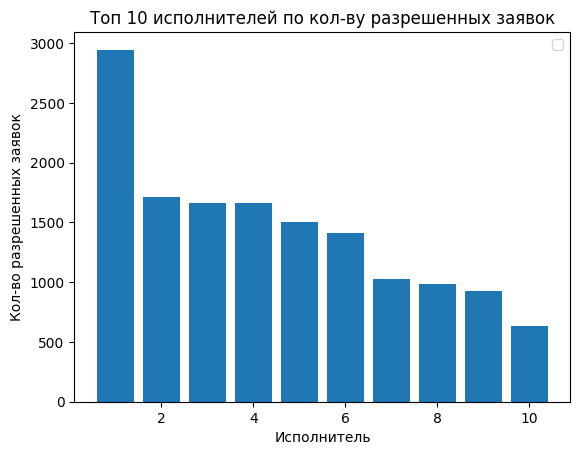

In [ ]:
plt.title("Топ 10 исполнителей по кол-ву разрешенных заявок")
plt.ylabel("Кол-во разрешенных заявок")
plt.xlabel("Исполнитель")
plt.bar([i + 1 for i in range(10)], top10Executors.values())
plt.legend()
plt.show()

In [ ]:
bidCategories = tatarDf["Категория, присвоенная модератором"].astype("category").unique()

bidCatPie = {"Другое": 0}
quantity = len(tatarDf.index)
for bCat in bidCategories:
  bCatQuantity = len((tatarDf[tatarDf["Категория, присвоенная модератором"] == bCat]).index)
  percent = bCatQuantity / quantity * 100
  if percent >= 2:
    bidCatPie[bCat] = percent
  else:
    bidCatPie["Другое"] = bidCatPie["Другое"] + percent

Выведем топ-10 категорий жалоб граждан

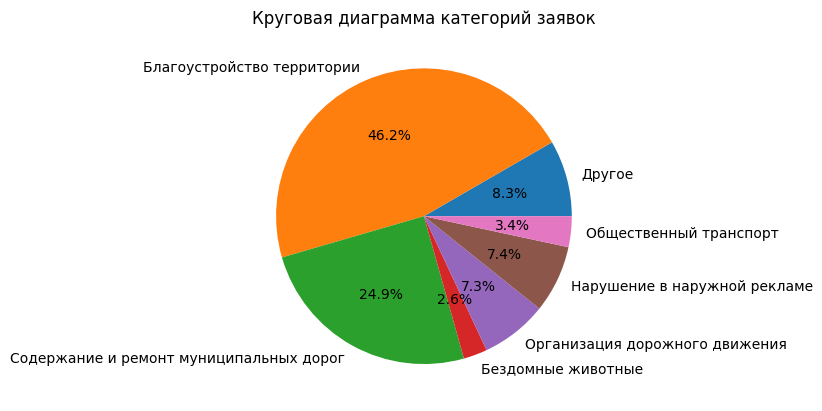

In [ ]:
plt.title("Круговая диаграмма категорий заявок")
plt.pie(bidCatPie.values(), labels = bidCatPie.keys(), autopct='%1.1f%%')
plt.show()

Как мы можем заметить, жителей Татарстана больше всего волнуют категории "Благоустройство территории" и "Содержание и ремонт муниципальных дорог"

Найдем топ-10 самых неразрешаемых категорий

In [ ]:
bidCatNotSolvedPie = {}


for bCat in bidCategories:
  bSCatQuantity = len((tatarDf[(tatarDf["Категория, присвоенная модератором"] == bCat)]))
  bSCatNotSolvedQuantity = len((tatarDf[(tatarDf["Категория, присвоенная модератором"] == bCat) & (tatarDf["Статус заявки"] != "Заявка решена")]).index)
  percent = bSCatNotSolvedQuantity / bSCatQuantity * 100
  bidCatNotSolvedPie[bCat] = percent

notSolved10Categories = {name : value for (name, value)  in zip(nlargest(15, bidCatNotSolvedPie),  nlargest(15, bidCatNotSolvedPie.values()))}

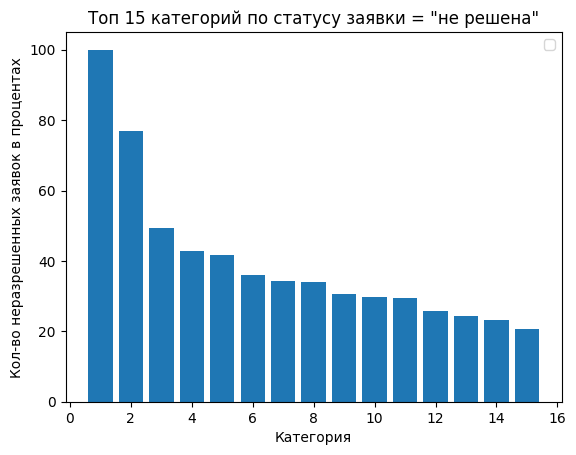

1 место: Цифровое телевидение (100.0 %)
2 место: Тех.средства и услуги по реабилитации инвалидов за счет средств федерального бюджета (76.92307692307693 %)
3 место: Социальное обслуживание (49.411764705882355 %)
4 место: Содержание и ремонт федеральных и республиканских дорог (42.78846153846153 %)
5 место: Содержание и ремонт муниципальных дорог (41.66666666666667 %)
6 место: Сельское хозяйство (35.8974358974359 %)
7 место: Санитарное состояние (34.23507462686567 %)
8 место: Садоводческие, огороднические и дачные некоммерческие объединения (34.01286085647832 %)
9 место: Работа учреждений культуры (30.555555555555557 %)
10 место: Работа спортивных объектов (29.71014492753623 %)
11 место: Почта (29.411764705882355 %)
12 место: Пособия безработным (25.895316804407713 %)
13 место: Поликлиники и больницы (24.343434343434346 %)
14 место: Пенсионное обеспечение (23.26900412492634 %)
15 место: Парки и скверы (20.705882352941178 %)


In [ ]:
plt.title("Топ 15 категорий по статусу заявки = \"не решена\"")
plt.ylabel("Кол-во неразрешенных заявок в процентах")
plt.xlabel("Категория")
plt.bar([i + 1 for i in range(15)], notSolved10Categories.values())
plt.legend()
plt.show()
for i, nSCat in enumerate(notSolved10Categories):
  print(f"{i + 1} место: {nSCat} ({list(notSolved10Categories.values())[i]} %)")

Найдем общую статистку статуса заявок

In [ ]:
bidStatus = tatarDf["Статус заявки"].astype("category").unique()
bidStatPie = {}

quantity = len(tatarDf.index)
for bStat in bidStatus:
  bStatQuantity = len((tatarDf[tatarDf["Статус заявки"] == bStat]).index)
  percent = bStatQuantity / quantity * 100
  bidStatPie[bStat] = percent


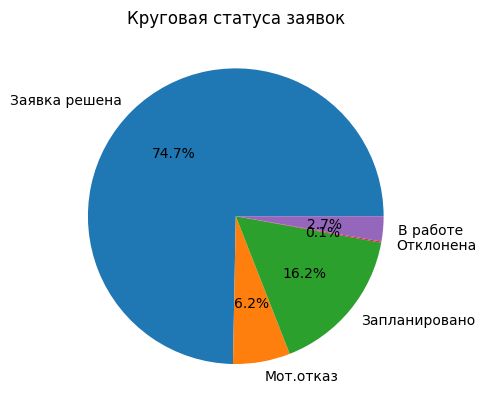

In [ ]:

plt.title("Круговая статуса заявок")
plt.pie(bidStatPie.values(), labels = bidStatPie.keys(), autopct='%1.1f%%')
plt.show()

# 2.2 Выбор переменных

Подключим все необходимое

Попытаемся вывести переменную "тональность" для каждого отзыва

In [ ]:
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

from dostoevsky.tokenization import RegexTokenizer

from dostoevsky.models import FastTextSocialNetworkModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=7b68a928be46af8aa4475a1c52109272bd217fe1d5adb40f972dcf5636173f85
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


Для начала, предобработаем заявки:
лемматизируем и токенизируем заявки

In [ ]:
def lemmatize1(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token:
          tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [ ]:
bids = tatarDf["Описание заявки"].apply(lemmatize1)
print(bids)

0        [На, трассе, Нижнекамск, Чистополь, в, лесопол...
1        [Во, дворе, дома, Ленинградская, отсутствуют, ...
2        [Добрый, день, Не, осуществляется, уборка, сне...
3        [Добрый, день, Не, осуществляется, вывоз, мусо...
4        [на, данном, участке, проезжей, части, от, ул,...
                               ...                        
29396    [После, сноса, гаражей, на, данной, территории...
29397    [Необходимо, установить, новый, забор, в, соот...
29398                                                 None
29399    [Свалка, отходов, мусора, в, гаражном, коопера...
29400    [Мачта, освещения, установлена, еще, в, прошло...
Name: Описание заявки, Length: 29401, dtype: object


Далее, попробуем вычислить вероятность эмоциональной окраски с помощью либы Dostoevsky

In [ ]:
tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

data1 = model.predict(tatarDf["Описание заявки"], k=5)

In [ ]:
neutral_list = []

negative_list = []

positive_list = []



for sentiment in data1:

        neutral_list.append(sentiment.get('neutral'))

        negative_list.append(sentiment.get('negative'))

        positive_list.append(sentiment.get('positive'))

In [ ]:
tatarDf['neutral'] = neutral_list

tatarDf['negative'] = negative_list

tatarDf['positive'] = positive_list

In [ ]:
print(tatarDf.head(3))

    Дата подачи заявки    Долгота     Широта  \
0  2019-01-01 00:00:00  51.339734  55.417592   
1  2019-01-01 00:00:00  52.456953  54.603573   
2  2019-01-01 00:00:00  49.126253  55.792942   

                                               Адрес  \
0  Чистополь — Нижнекамск, Ачи, Нижнекамский райо...   
1  29, Ленинградская улица, городское поселение Л...   
2  Россия, Республика Татарстан, Казань, улица Га...   

        Категория, присвоенная модератором  \
0               Благоустройство территории   
1               Благоустройство территории   
2  Содержание и ремонт муниципальных дорог   

                                     Описание заявки  \
0  На трассе Нижнекамск-Чистополь в лесополосе у ...   
1  Во дворе дома Ленинградская 29 отсутствуют пар...   
2  Добрый день! Не осуществляется уборка снега в ...   

                               Последний исполнитель id исполнителя  \
0  Исполнительный комитет Нижнекамского муниципал...        22291.0   
1  Исполнительный комитет Лени

# 3.

In [ ]:
import gensim.models

In [ ]:
model = gensim.models.Word2Vec(sentences = tatarDf["Подготовленный текст"], min_count = 5, vector_size=50)

In [ ]:
model.wv["казань"]

array([ 1.9946229e+00, -1.0566978e+00, -3.6113879e-01,  9.0268010e-01,
       -8.6619490e-01, -2.4987457e+00, -7.8866565e-01,  1.3540927e+00,
       -2.3040094e+00, -2.7278271e+00,  8.8340765e-01, -1.7767218e+00,
       -1.9290017e-01,  9.3212950e-01,  2.9289639e-01,  1.4388710e+00,
        9.7670662e-01,  1.5842351e+00, -2.9045994e+00,  8.9917324e-02,
       -1.1369467e+00, -3.1475374e-01, -8.4888911e-01, -3.3888689e-01,
        7.5776458e-01, -6.1716843e-01, -4.5024854e-01, -8.2256703e-04,
       -1.7562263e+00,  1.3750213e-01, -4.5060974e-01,  4.6335682e-02,
       -7.3862362e-01, -8.7534636e-01, -8.4069170e-02, -4.1755444e-01,
        1.3849344e+00,  9.4324893e-01, -1.8895854e-01, -2.0459525e-01,
       -1.5373152e+00, -8.5751617e-01, -7.4839032e-01, -2.0378013e+00,
        1.1770947e+00, -6.1642748e-01,  4.1135949e-01,  5.7769823e-01,
        3.5490823e-01,  1.3774909e+00], dtype=float32)

In [ ]:
texts = tatarDf["Описание заявки"]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01,
                                 use_idf=True, tokenizer=lemmatize, ngram_range=(1,3))

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(tatarDf["Описание заявки"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:




print(tatarDf["Категория, присвоенная модератором"].astype("category"))

0                     Благоустройство территории
1                     Благоустройство территории
2        Содержание и ремонт муниципальных дорог
3                     Благоустройство территории
4        Содержание и ремонт муниципальных дорог
                          ...                   
29396                 Благоустройство территории
29397                 Благоустройство территории
29398                 Благоустройство территории
29399                                     Cвалки
29400                 Благоустройство территории
Name: Категория, присвоенная модератором, Length: 29401, dtype: category
Categories (36, object): ['Cвалки', 'Бездомные животные', 'Благоустройство территории',
                          'Вода', ..., 'Содержание и ремонт федеральных и республикан...,
                          'Социальное обслуживание', 'Тех.средства и услуги по реабилитации инвалид...,
                          'Цифровое телевидение']


In [ ]:
num_clusters = 36

# Метод к-средних - KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters)

In [ ]:
km.fit(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=36)

In [ ]:


clusterkm = km.labels_.tolist()
frame = pd.DataFrame(texts)

#k-means
out = { 'text': texts, 'cluster': clusterkm, 'topic': tatarDf['Категория, присвоенная модератором'] }
frame1 = pd.DataFrame(out, columns = ['text', 'cluster', 'topic'])



In [ ]:


frame1.head(10)



,text,cluster,topic
0,На трассе Нижнекамск-Чистополь в лесополосе у ...,1,Благоустройство территории
1,Во дворе дома Ленинградская 29 отсутствуют пар...,0,Благоустройство территории
2,Добрый день! Не осуществляется уборка снега в ...,3,Содержание и ремонт муниципальных дорог
3,Добрый день! Не осуществляется вывоз мусора с ...,0,Благоустройство территории
4,на данном участке проезжей части от ул.Халитов...,1,Содержание и ремонт муниципальных дорог
5,Невозможно записать ребенка на прием через гос...,17,Поликлиники и больницы
6,Прошу устранить недостатки. Закрасить,3,Благоустройство территории
7,"На поле возле Марии соорудили площадку, похожу...",19,Благоустройство территории
8,Плохо очищена проезжая часть на Проспекте Побе...,3,Содержание и ремонт муниципальных дорог
9,Правая часть проезжей части по Мамадышскому тр...,1,Содержание и ремонт муниципальных дорог


In [ ]:
clust_res = pd.DataFrame(columns=[f"cluster_{i}" for i in range(37)])
i = 0
topics = list(tatarDf["Категория, присвоенная модератором"].astype("category"))

for topic in topics:
    cnt = []
    for cluster in range(num_clusters):
        cnt.append(len(frame1[ frame1.topic.eq(topic) &  frame1.cluster.eq(cluster) ]))
    clust_res.loc[i] = [topic] + cnt
    i += 1
clust_res

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36
0,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
1,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
2,Содержание и ремонт муниципальных дорог,397,502,29,1659,1216,512,146,8,121,...,0,94,193,0,65,4,8,5,2,162
3,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
4,Содержание и ремонт муниципальных дорог,397,502,29,1659,1216,512,146,8,121,...,0,94,193,0,65,4,8,5,2,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29396,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
29397,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
29398,Благоустройство территории,931,224,261,3018,312,44,317,56,151,...,26,285,104,9,179,612,37,611,27,238
29399,Cвалки,6,2,5,41,9,0,13,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
max = clust_res.max()

NameError: ignored